## Importing

In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from dython.nominal import identify_nominal_columns
from feature_engine.creation import CyclicalFeatures
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM, Dropout
from keras.layers import Dense
from keras.layers import Bidirectional
from dtreeviz.trees import dtreeviz
import category_encoders as ce
import warnings
import math
warnings.filterwarnings("ignore")

## EDA 

In [182]:
# Import the data and parse the date column
data = pd.read_csv("LU Grp project data - Co-op ISB forecasting.csv", parse_dates=["Transaction_date"])
# Sort the data by date
data = data.sort_values(by='Transaction_date', ascending=True)
print(data.shape)
data.head()

(51962, 27)


Store_Number                                Store_Name  Product_Code  \
35562          5751  Heysham                                         710651   
36662          8040  Caton                                           800544   
43642          8037  High Bentham                                    740282   
27880          3446  Petrol Three Peaks                              698186   
44569          8040  Caton                                           673160   

                                     Product_Description SubSect_Description  \
35562                Co-op White Farmhouse Loaf PMP 800G  ISB - WHITE LOAVES   
36662  Co-op Irresistible Extra Mature Cheddar & Jala...  ISB - WMEAL LOAVES   
43642    Co-op Pumpkin & Sunflower Seed Square Roll EACH          ISB - ROLL   
27880                               Co-op Cheese Baps 4S          ISB - ROLL   
44569                   Co-op White Rustic Roll NOS EACH          ISB - ROLL   

      Transaction_date  OPENING_TIME  CLOSING_TIME  MONDAY  TUESDAY  ...  \
35562       2021-05-01           700          2200       0        0  ...   
36662       2021-05-01           700          2200       0        0  ...   
43642       2021-05-01           700          2200       0        0  ...   
27880       2021-05-01           600          2200       0        0  ...   
44569       2021-05-01           700          2200       0        0  ...   

       SPRING  SUMMER  AUTUMN  Weather_Feels_Like  Weather_Rain  \
35562       1       0       0                  11             0   
36662       1       0       0                  11             0   
43642       1       0       0                  11             0   
27880       1       0       0                  11             0   
44569       1       0       0                  11             0   

       Weather_Cloud  Full_Price_Sales_Quantity  Full_Price_Sales_Turnover  \
35562             82                          2                       2.80   
36662             82                          2                       3.80   
43642             82                          4                       1.60   
27880             82                          9                       9.45   
44569             82                          6                       2.00   

       Reduced_To_Clear_Quantity  Reduced_To_Clear_Turnover  
35562                          0                       0.00  
36662                          4                       3.04  
43642                          0                       0.00  
27880                          0                       0.00  
44569                          0                       0.00  

[5 rows x 27 columns]

In [183]:
# Get basic information about data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51962 entries, 35562 to 46610
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store_Number               51962 non-null  int64         
 1   Store_Name                 51962 non-null  object        
 2   Product_Code               51962 non-null  int64         
 3   Product_Description        51962 non-null  object        
 4   SubSect_Description        51962 non-null  object        
 5   Transaction_date           51962 non-null  datetime64[ns]
 6   OPENING_TIME               51962 non-null  int64         
 7   CLOSING_TIME               51962 non-null  int64         
 8   MONDAY                     51962 non-null  int64         
 9   TUESDAY                    51962 non-null  int64         
 10  WEDNESDAY                  51962 non-null  int64         
 11  THURSDAY                   51962 non-null  int64         
 12  

In [184]:
# basic statistical information about data
data.describe()

Store_Number   Product_Code  OPENING_TIME  CLOSING_TIME        MONDAY  \
count  51962.000000   51962.000000  51962.000000  51962.000000  51962.000000   
mean    6745.786556  728935.648262    684.950541   2195.795004      0.145683   
std     1529.841110   50353.291290     55.371281     76.276082      0.352792   
min     3446.000000  673134.000000    600.000000   1600.000000      0.000000   
25%     5343.000000  673160.000000    700.000000   2200.000000      0.000000   
50%     7867.000000  735944.000000    700.000000   2200.000000      0.000000   
75%     8048.000000  755255.000000    700.000000   2200.000000      0.000000   
max     8093.000000  853872.000000   1000.000000   2300.000000      1.000000   

            TUESDAY     WEDNESDAY      THURSDAY        FRIDAY      SATURDAY  \
count  51962.000000  51962.000000  51962.000000  51962.000000  51962.000000   
mean       0.145241      0.142739      0.140025      0.141873      0.142758   
std        0.352347      0.349810      0.347017      0.348923      0.349829   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       ...        SPRING        SUMMER        AUTUMN  Weather_Feels_Like  \
count  ...  51962.000000  51962.000000  51962.000000        51962.000000   
mean   ...      0.272353      0.374889      0.181132           11.832262   
std    ...      0.445175      0.484099      0.385132            7.063901   
min    ...      0.000000      0.000000      0.000000           -9.000000   
25%    ...      0.000000      0.000000      0.000000            6.000000   
50%    ...      0.000000      0.000000      0.000000           13.000000   
75%    ...      1.000000      1.000000      0.000000           17.000000   
max    ...      1.000000      1.000000      1.000000           35.000000   

       Weather_Rain  Weather_Cloud  Full_Price_Sales_Quantity  \
count  51962.000000   51962.000000               51962.000000   
mean       0.250337      93.401466                   4.017128   
std        0.504319      12.604784                   3.570299   
min        0.000000      13.000000                  -1.000000   
25%        0.000000      88.000000                   2.000000   
50%        0.000000     100.000000                   3.000000   
75%        0.000000     100.000000                   5.000000   
max        3.000000     100.000000                  43.000000   

       Full_Price_Sales_Turnover  Reduced_To_Clear_Quantity  \
count               51962.000000               51962.000000   
mean                    3.326708                   0.299950   
std                     2.883242                   0.762658   
min                    -2.000000                   0.000000   
25%                     1.300000                   0.000000   
50%                     2.400000                   0.000000   
75%                     4.400000                   0.000000   
max                    35.060000                  15.000000   

       Reduced_To_Clear_Turnover  
count                51962.00000  
mean                     0.14816  
std                      0.40665  
min                      0.00000  
25%                      0.00000  
50%                      0.00000  
75%                      0.00000  
max                     12.60000  

[8 rows x 23 columns]

In [185]:
# Removing negative values for sales quantity
data = data[data['Full_Price_Sales_Quantity'] >= 0].reset_index(drop=True)
data.shape

(51959, 27)

2021-05-01 00:00:00 2022-08-31 00:00:00
    Store_Number                                Store_Name
0           5751  Heysham                                 
1           8040  Caton                                   
2           8037  High Bentham                            
3           3446  Petrol Three Peaks                      
5           5147  Heysham- Middleton Road                 
6           6002  Bolton-Le-Sands, Bye Pass Road          
8           7867  Morecambe                               
9           8048  Carnforth                               
11          8093  Regent Road                             
19          8051  Emsgate Lane - Silverdale               
20          5343  Quernmore Road - Lancaster              
29          8042  Ingleton                                
    Product_Code                                Product_Description  \
0         710651                Co-op White Farmhouse Loaf PMP 800G   
1         800544  Co-op Irresistible Extra Mature C

<AxesSubplot:ylabel='Density'>

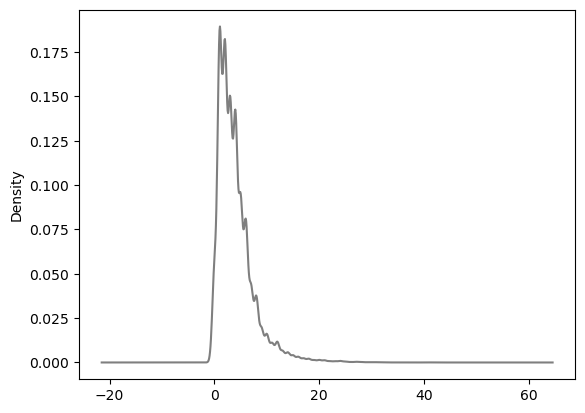

In [186]:
# Time period 
print(min(data['Transaction_date']), max(data['Transaction_date']))
# Number of stores -> 12
print(data[['Store_Number', 'Store_Name']].drop_duplicates())
# Number of products -> 16
print(data[['Product_Code', 'Product_Description', 'SubSect_Description']].drop_duplicates())
# Distribution of sales quantity
data['Full_Price_Sales_Quantity'].plot.density(color='k', alpha=0.5)

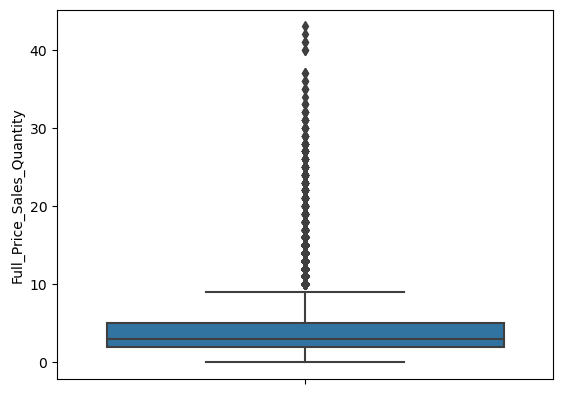

In [187]:
sns.boxplot( y=data["Full_Price_Sales_Quantity"] )
plt.show()

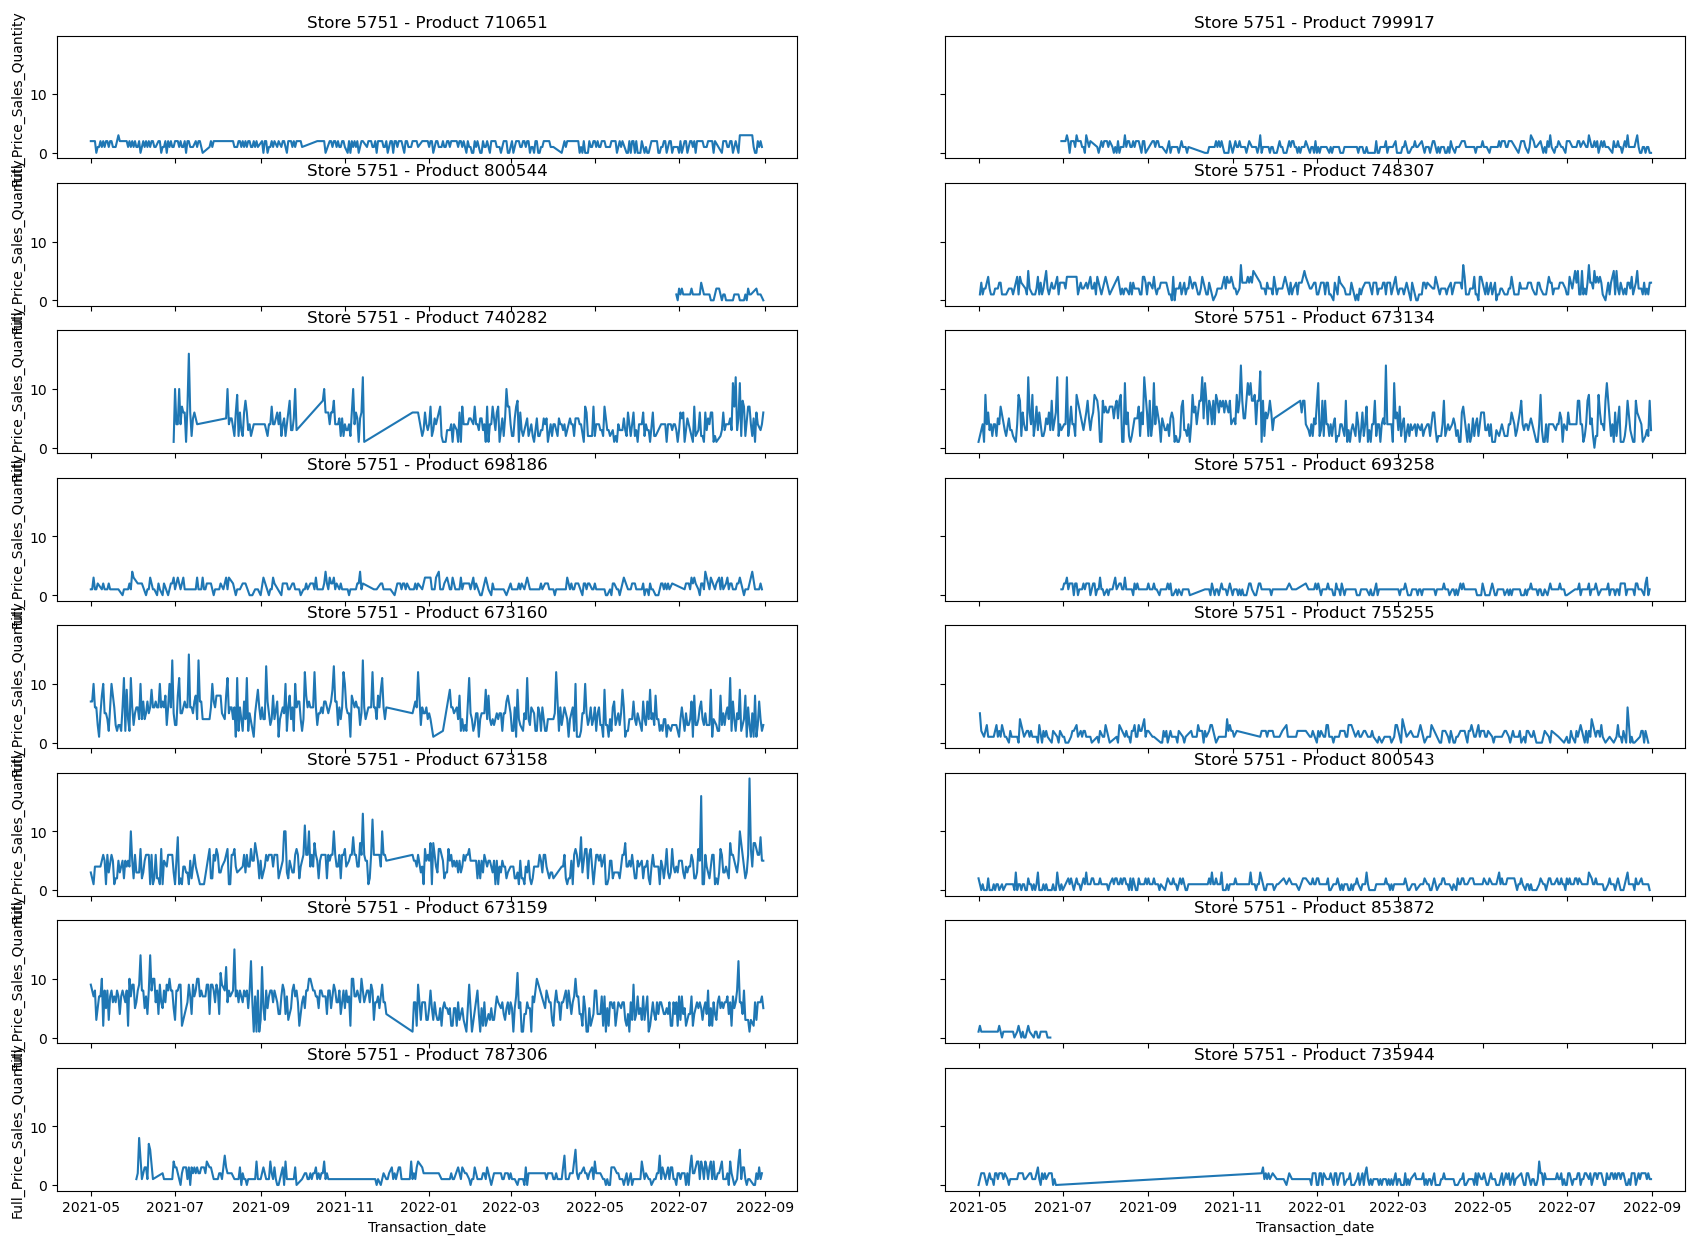

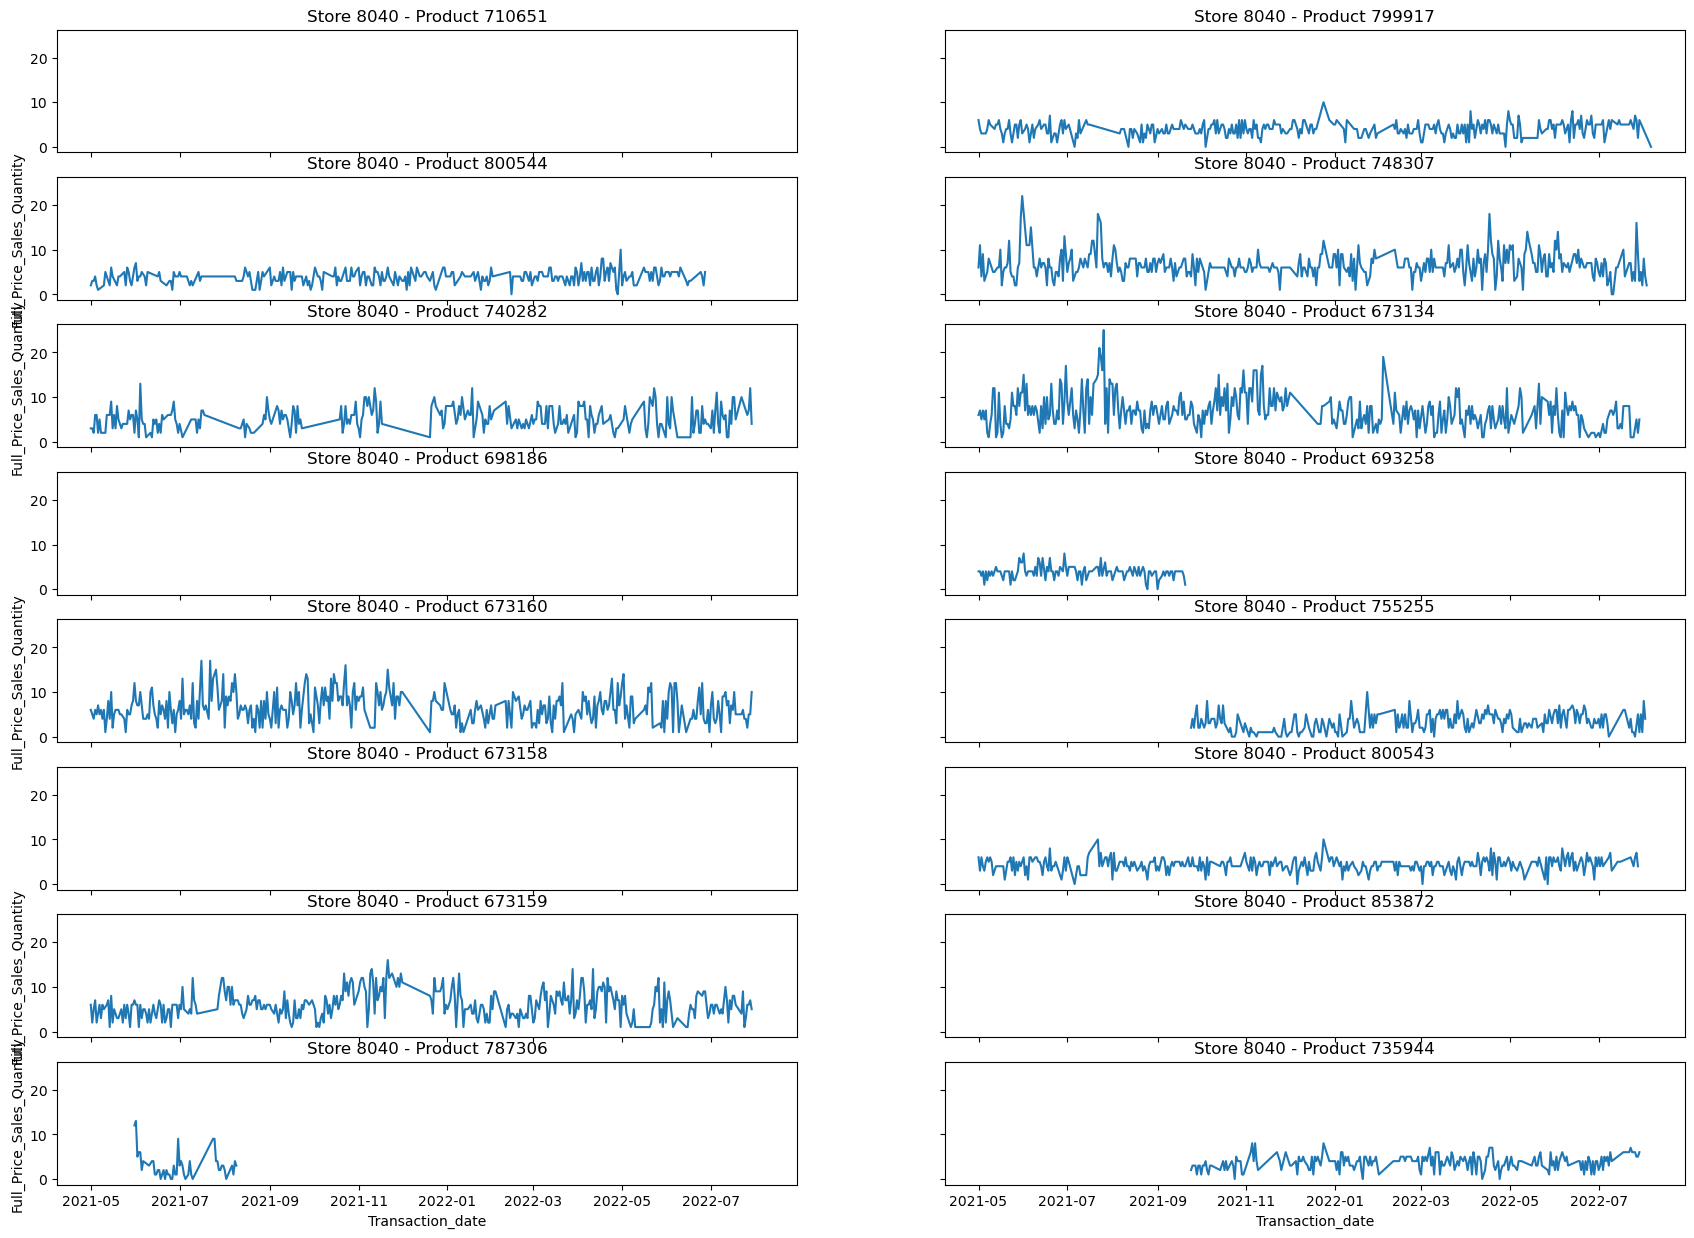

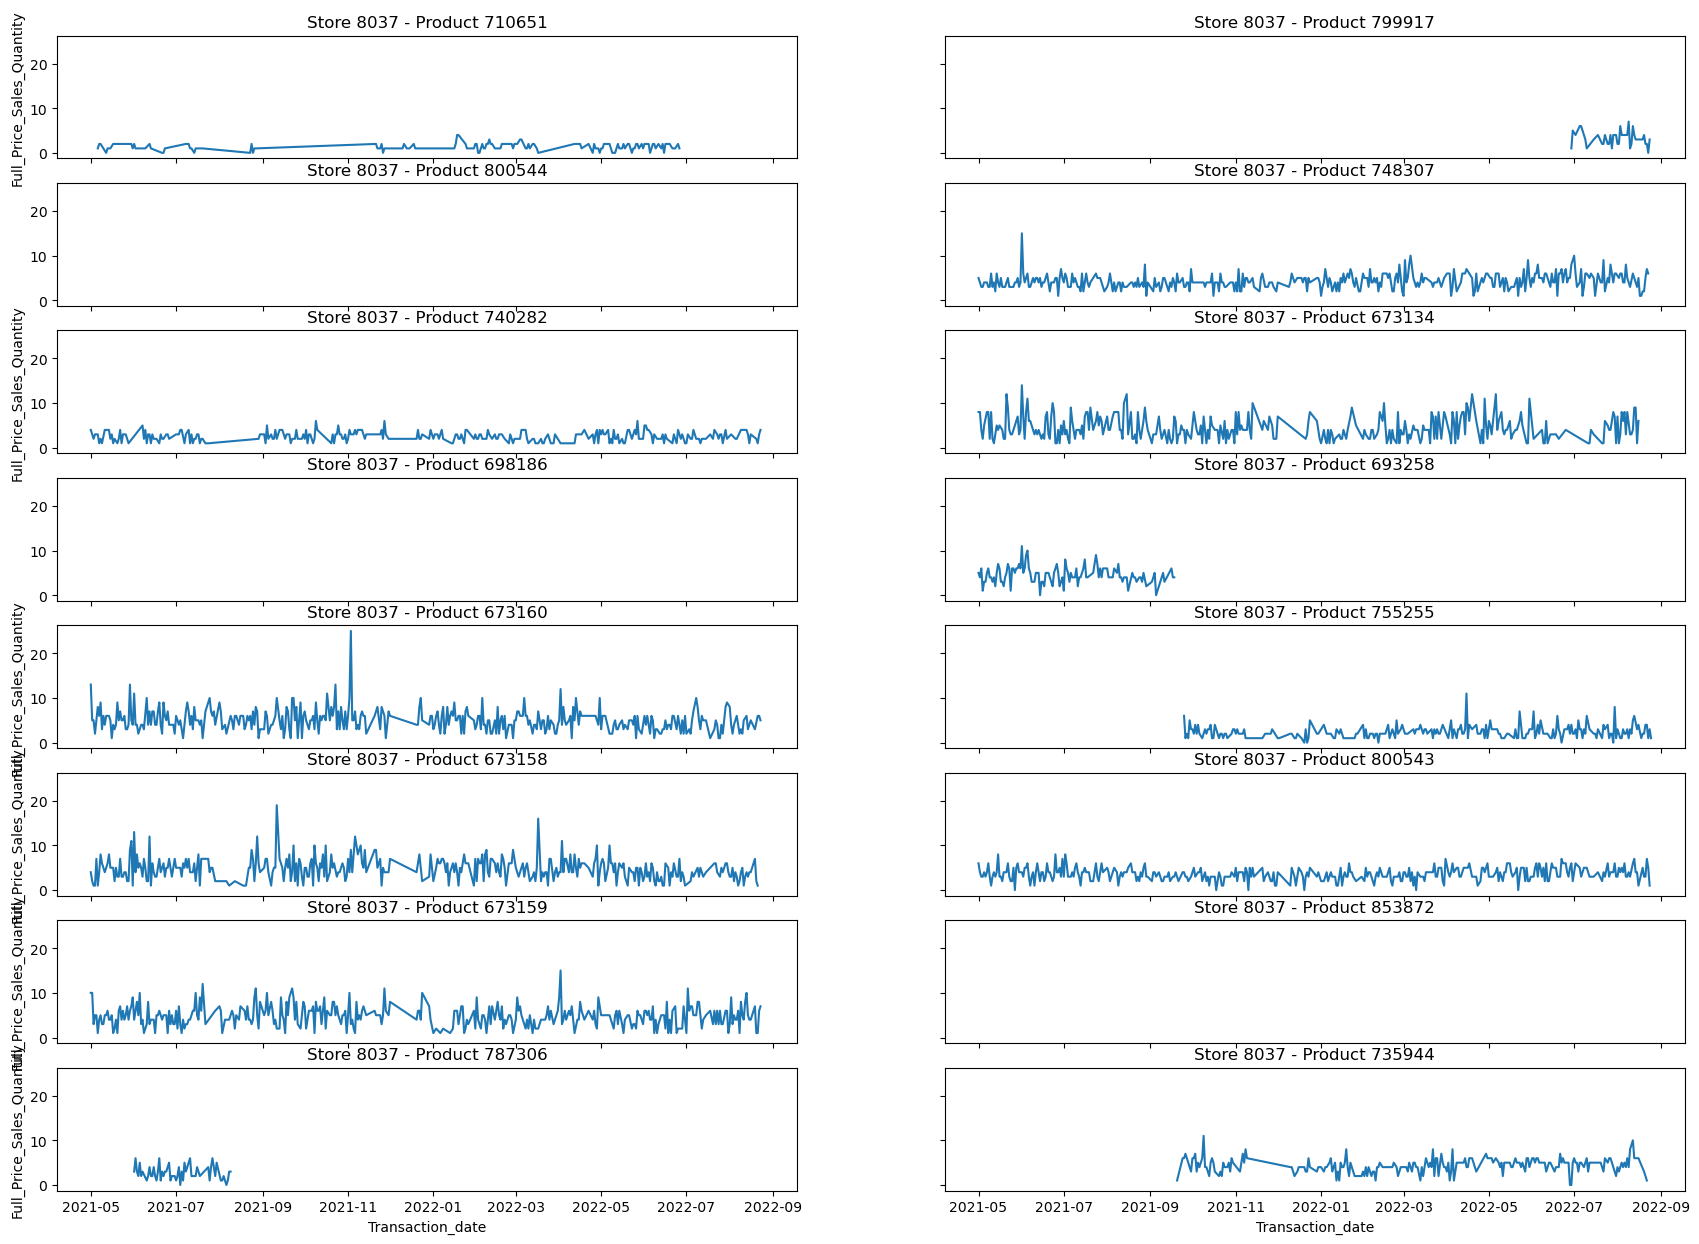

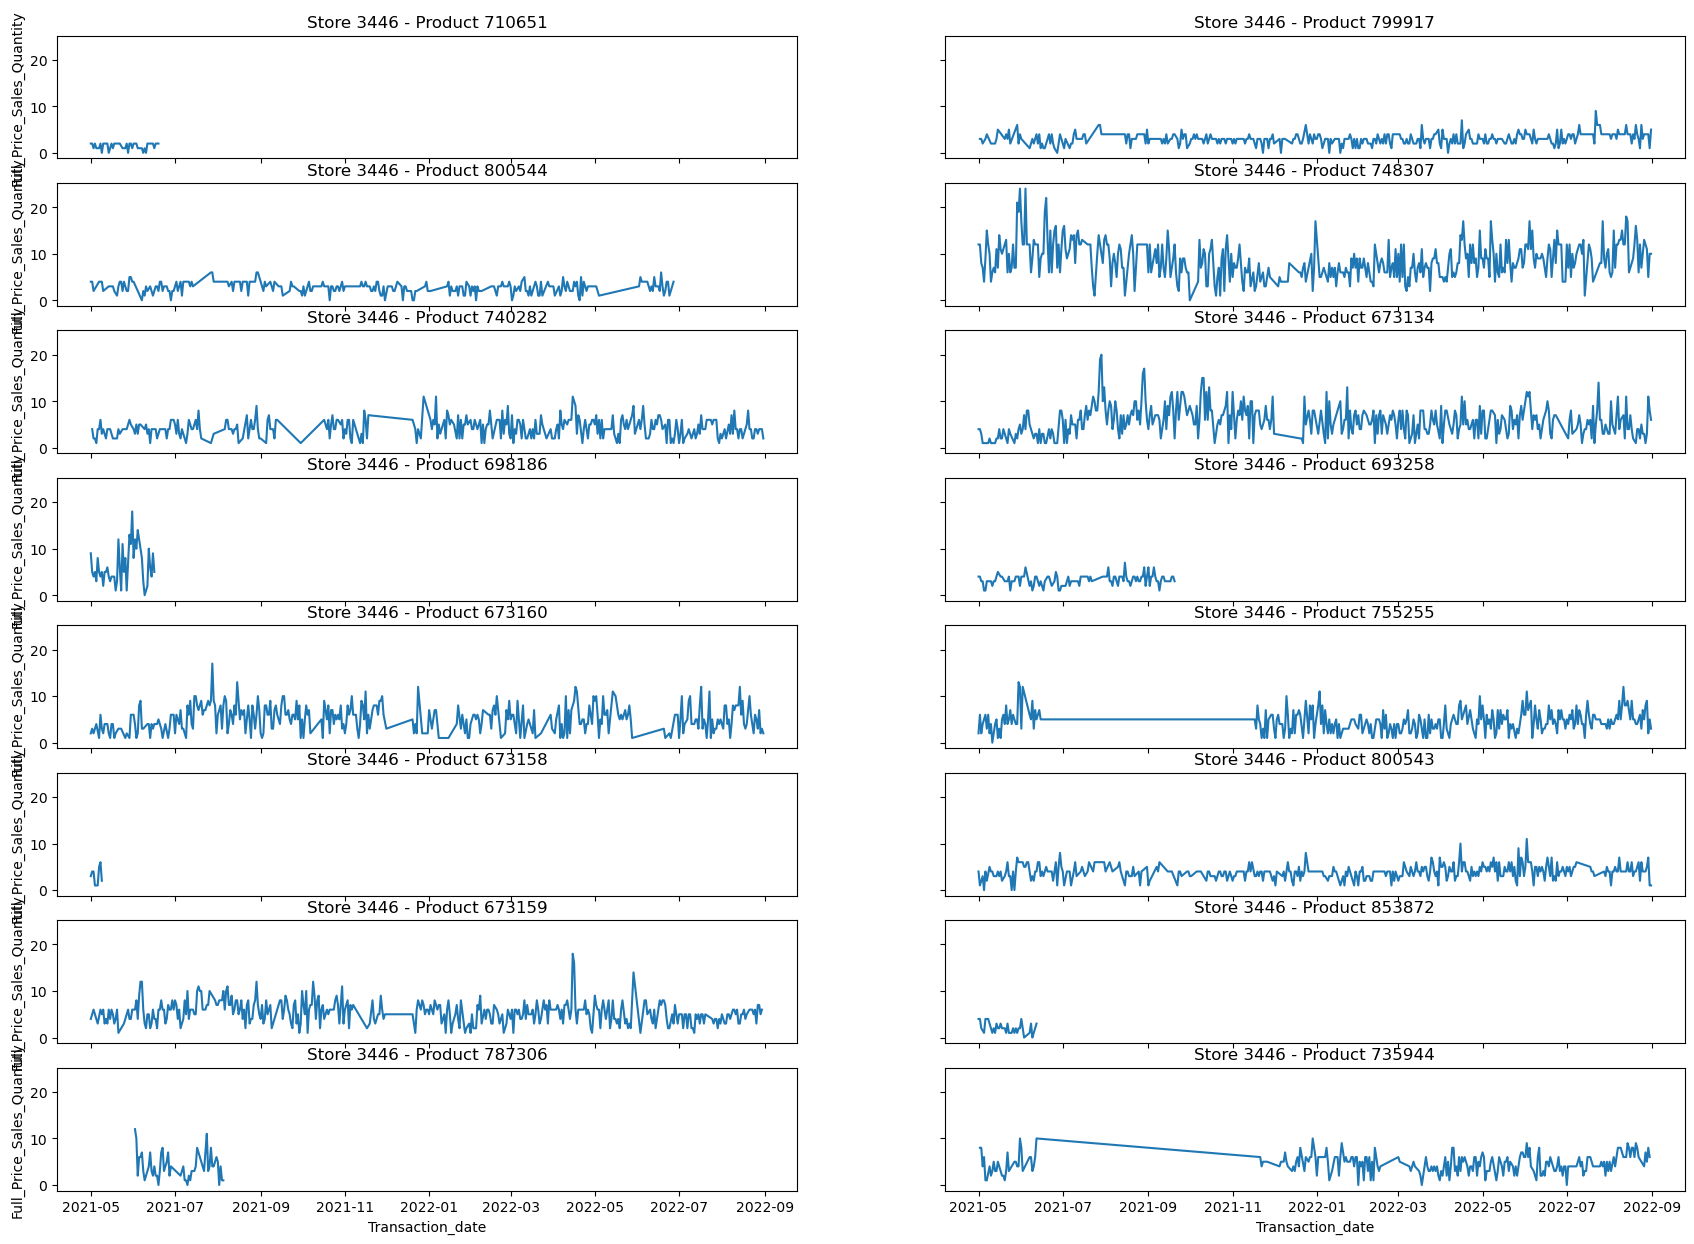

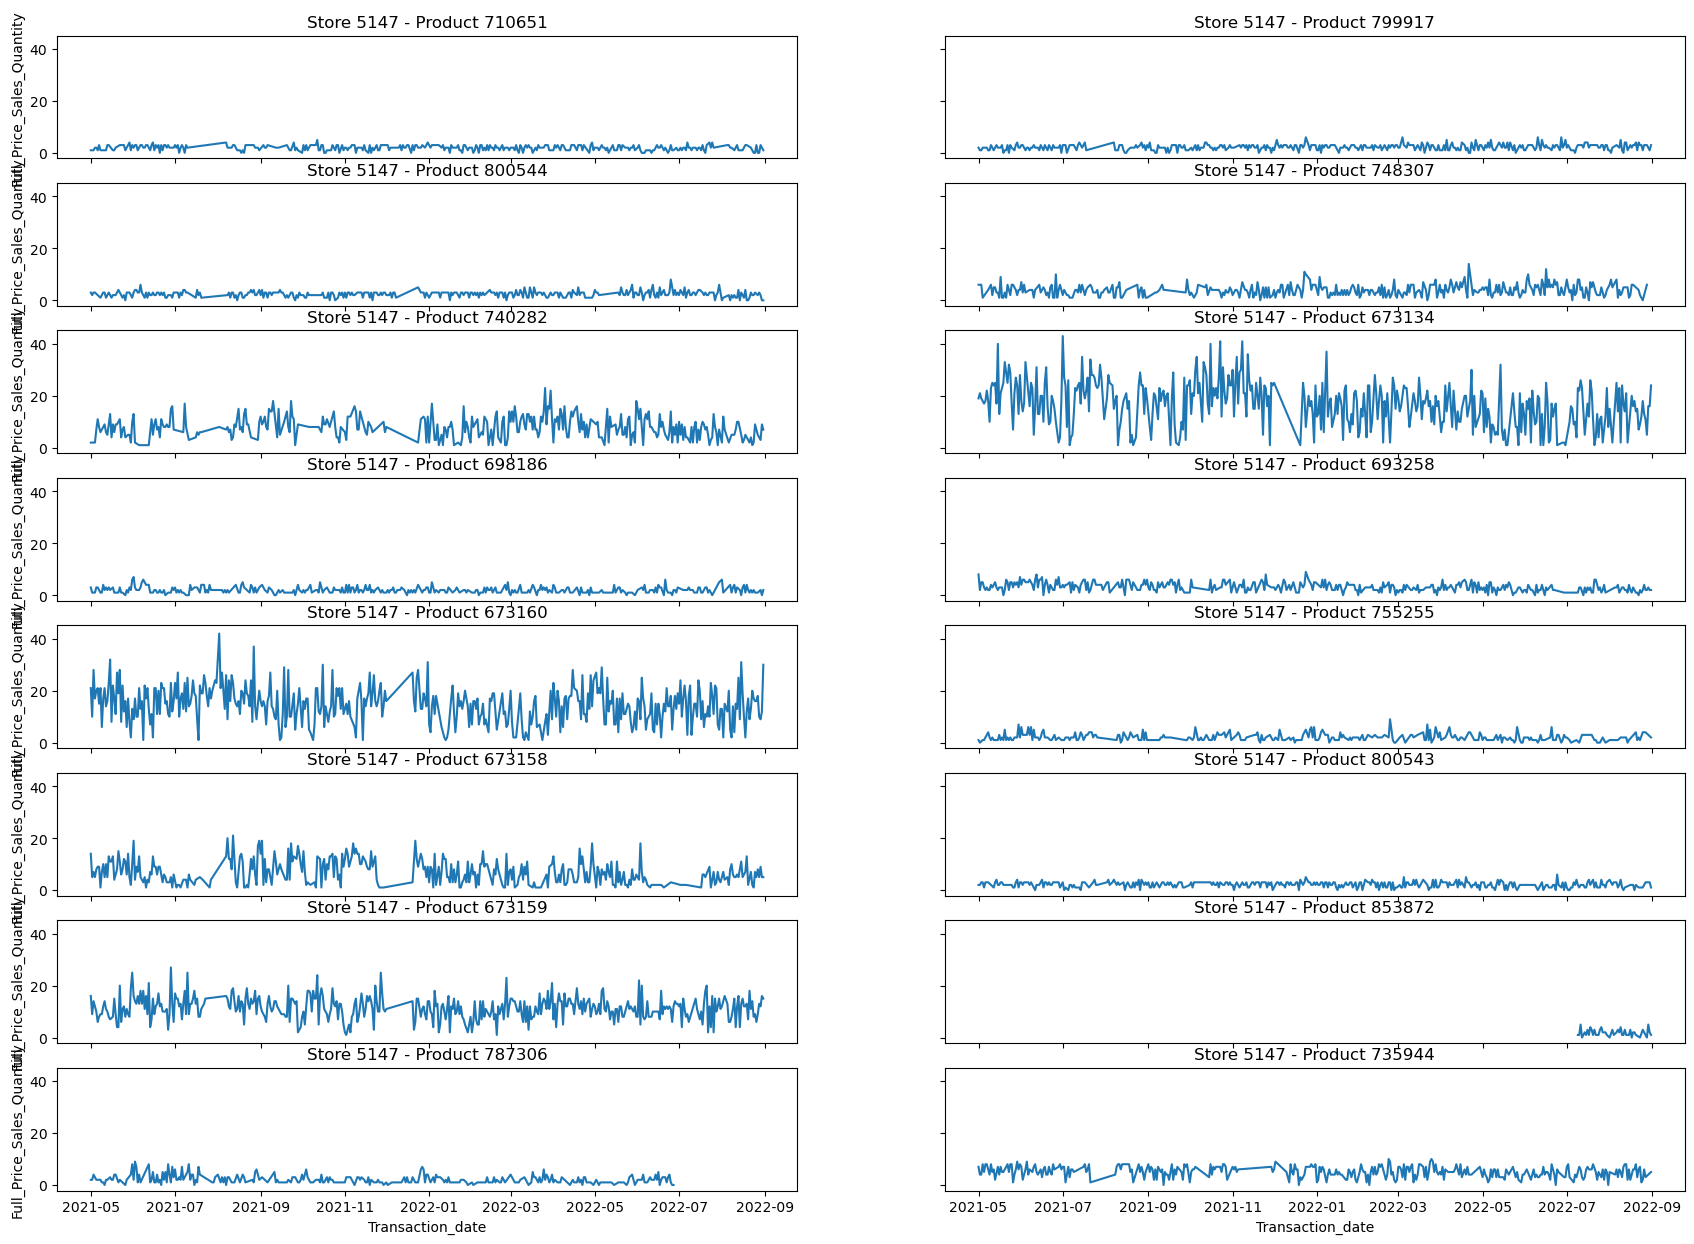

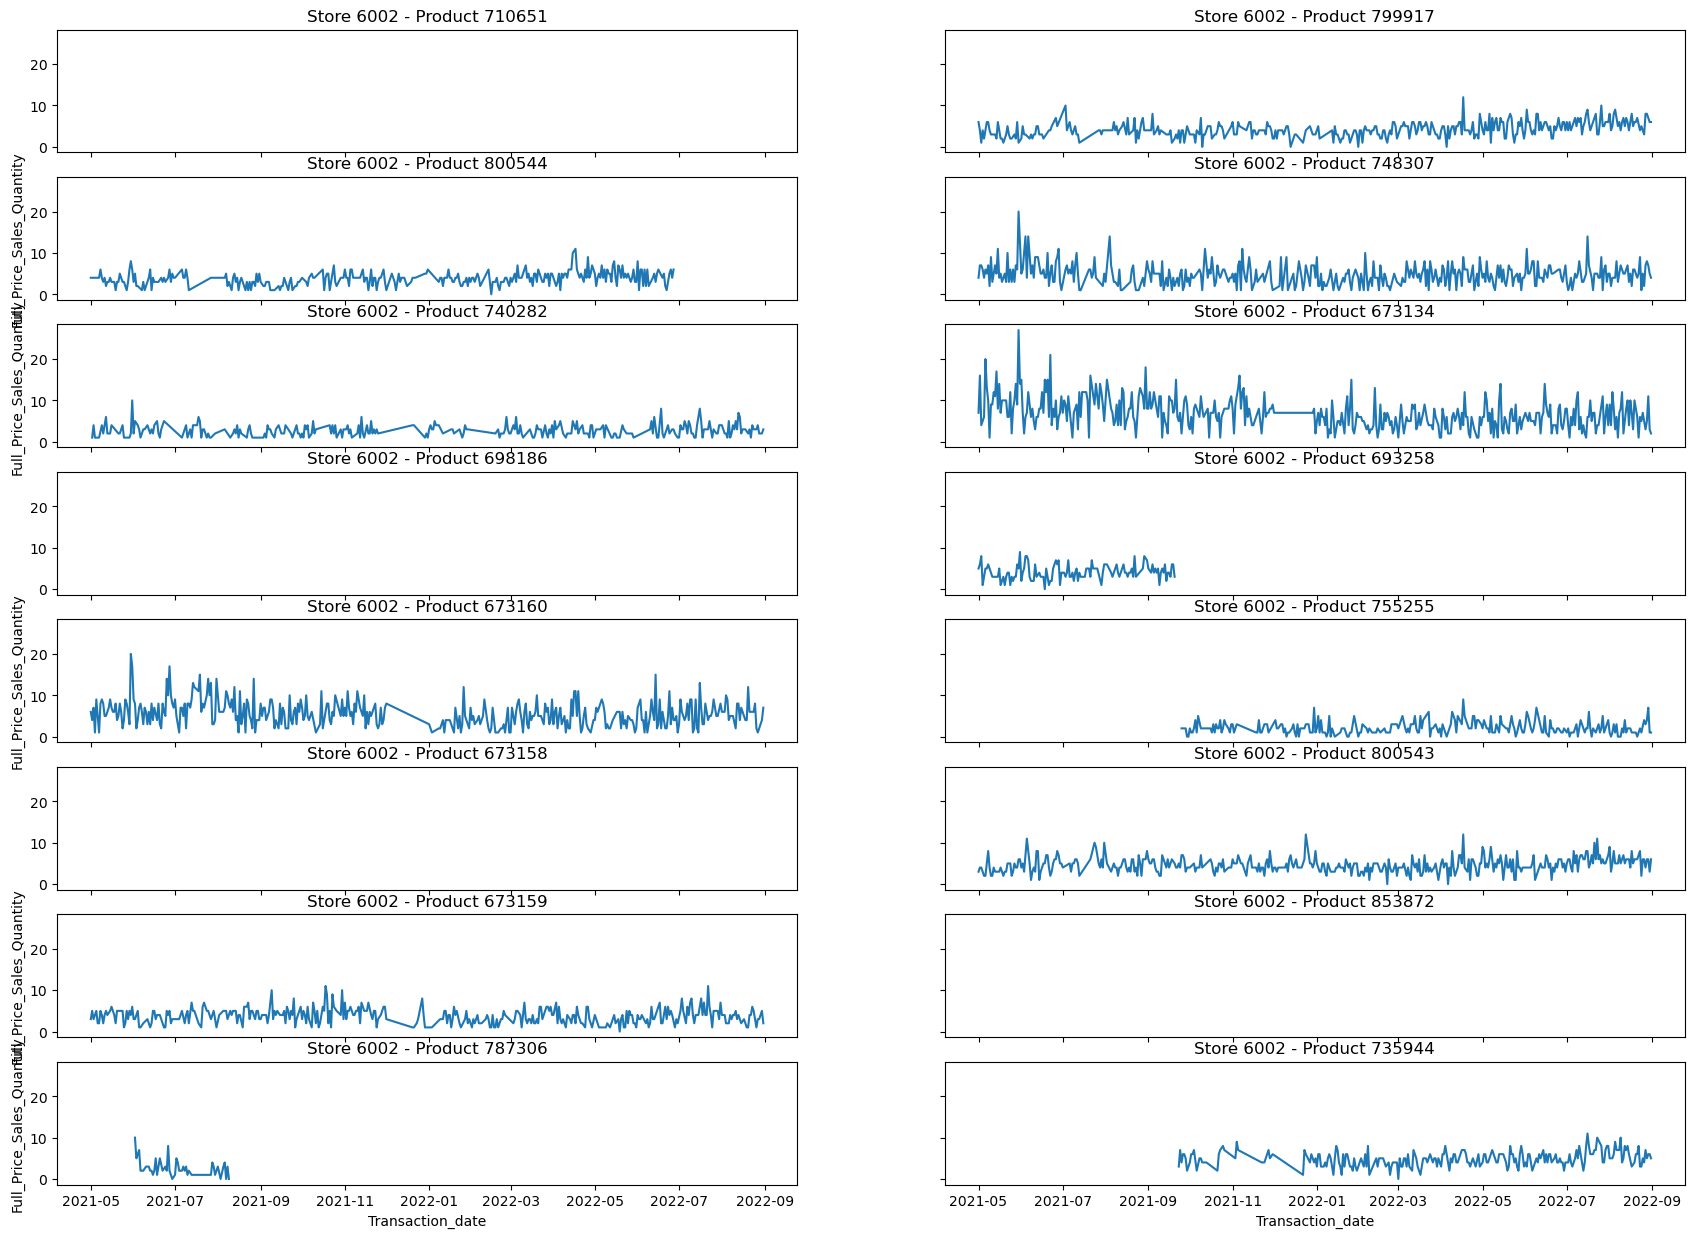

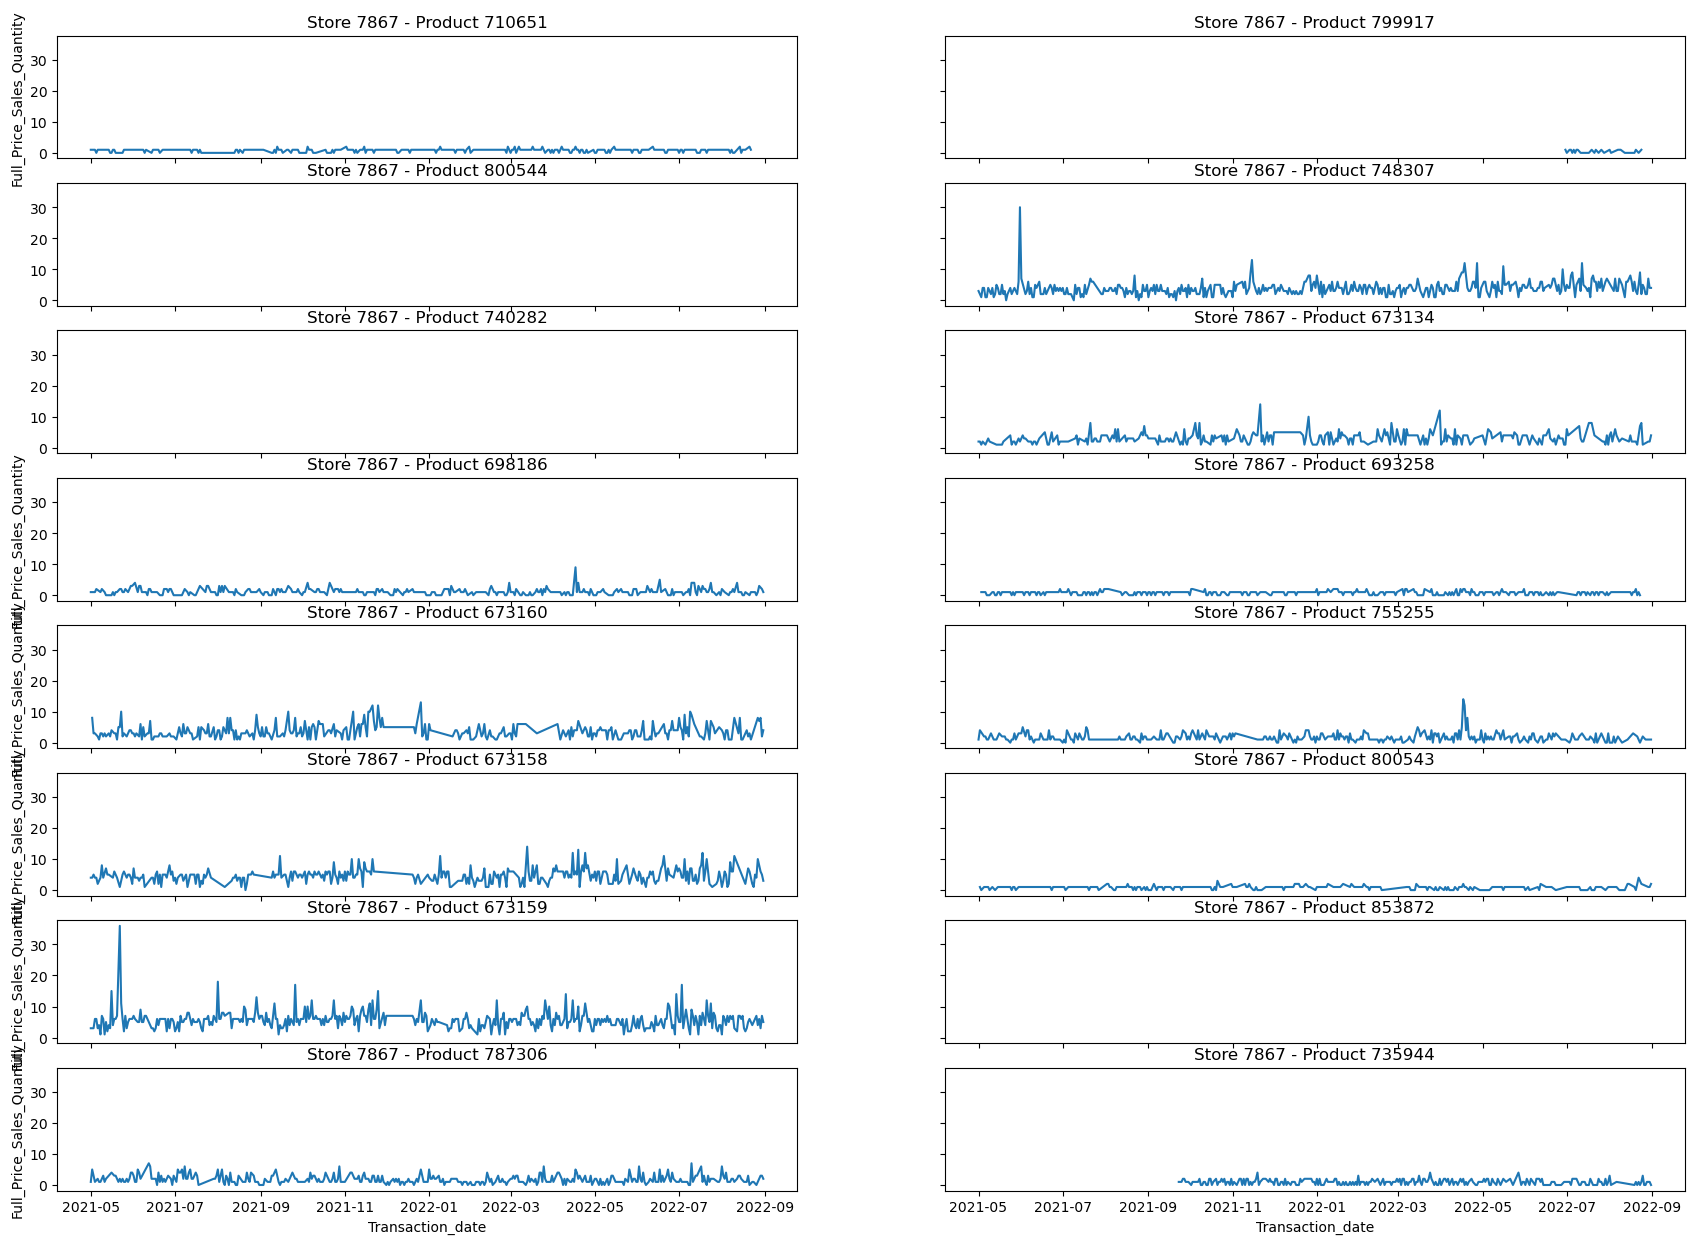

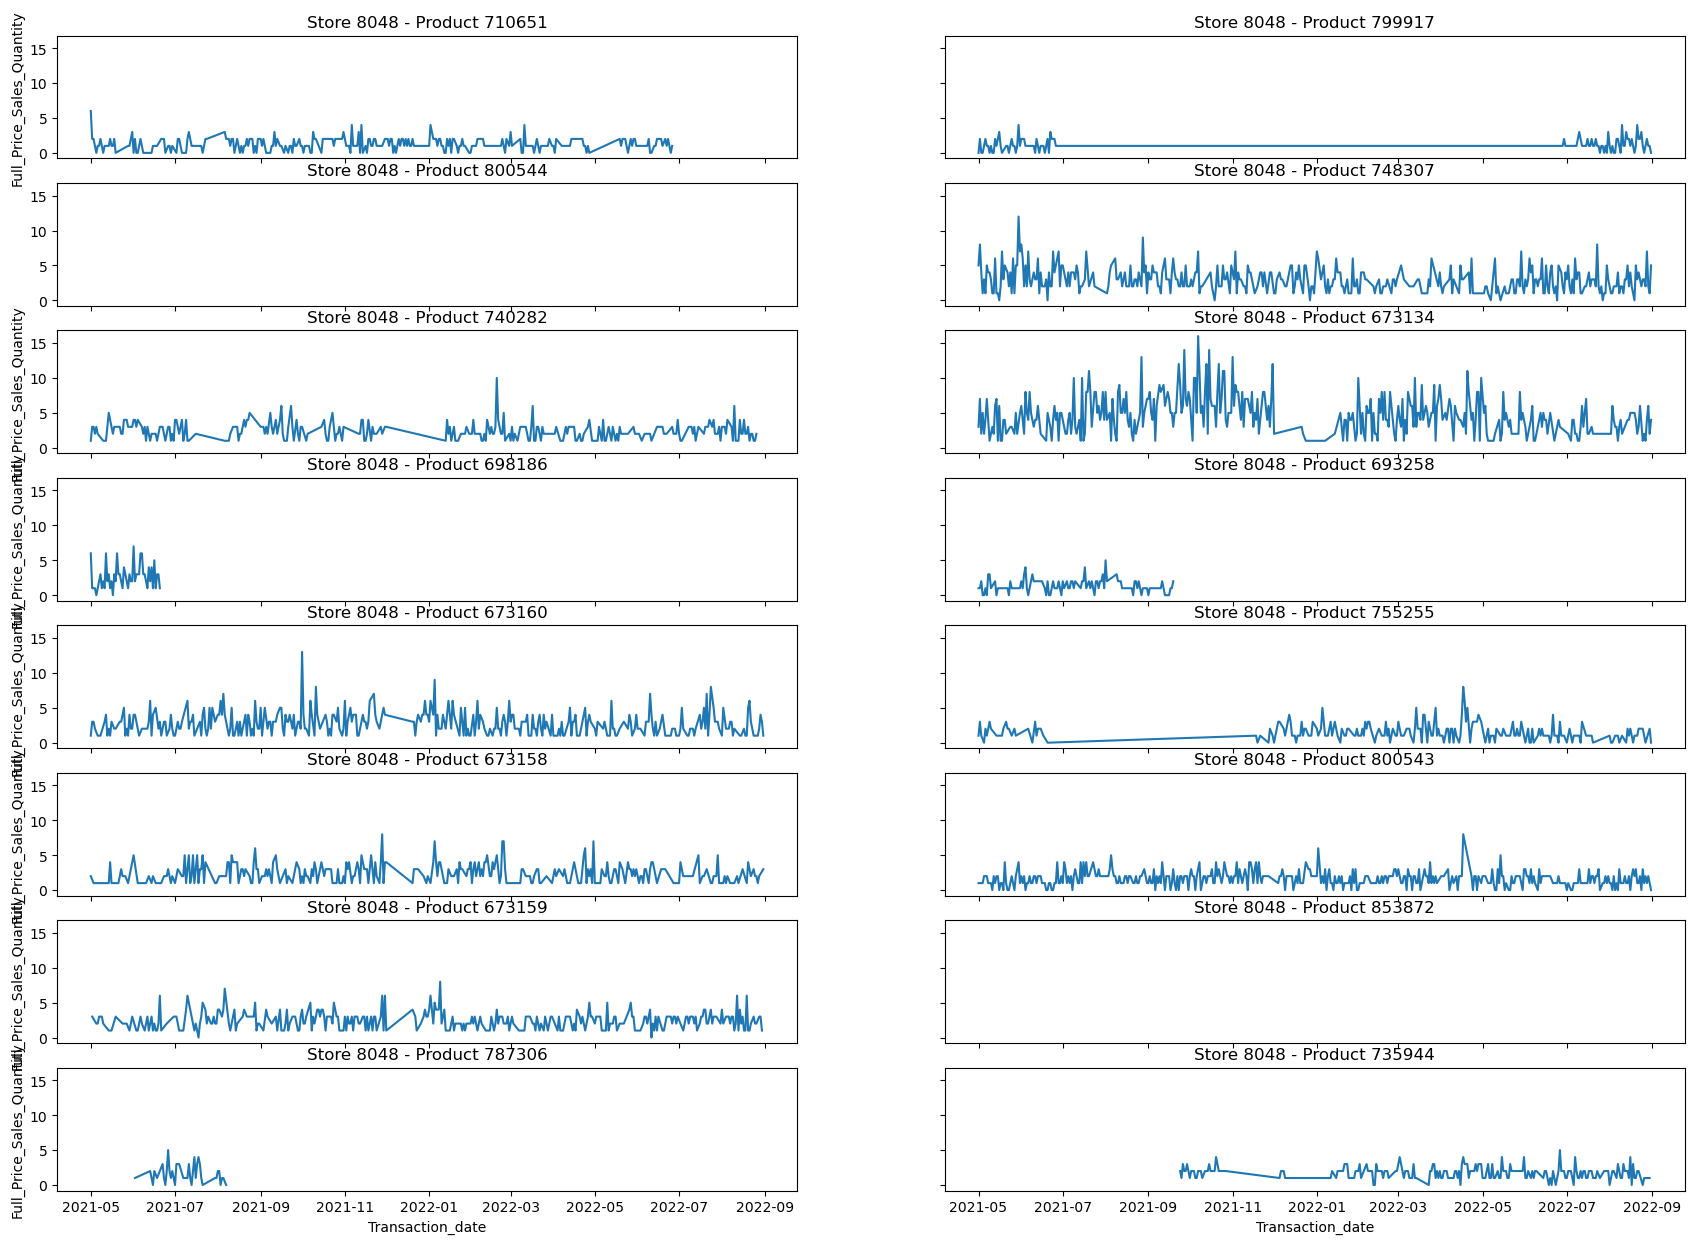

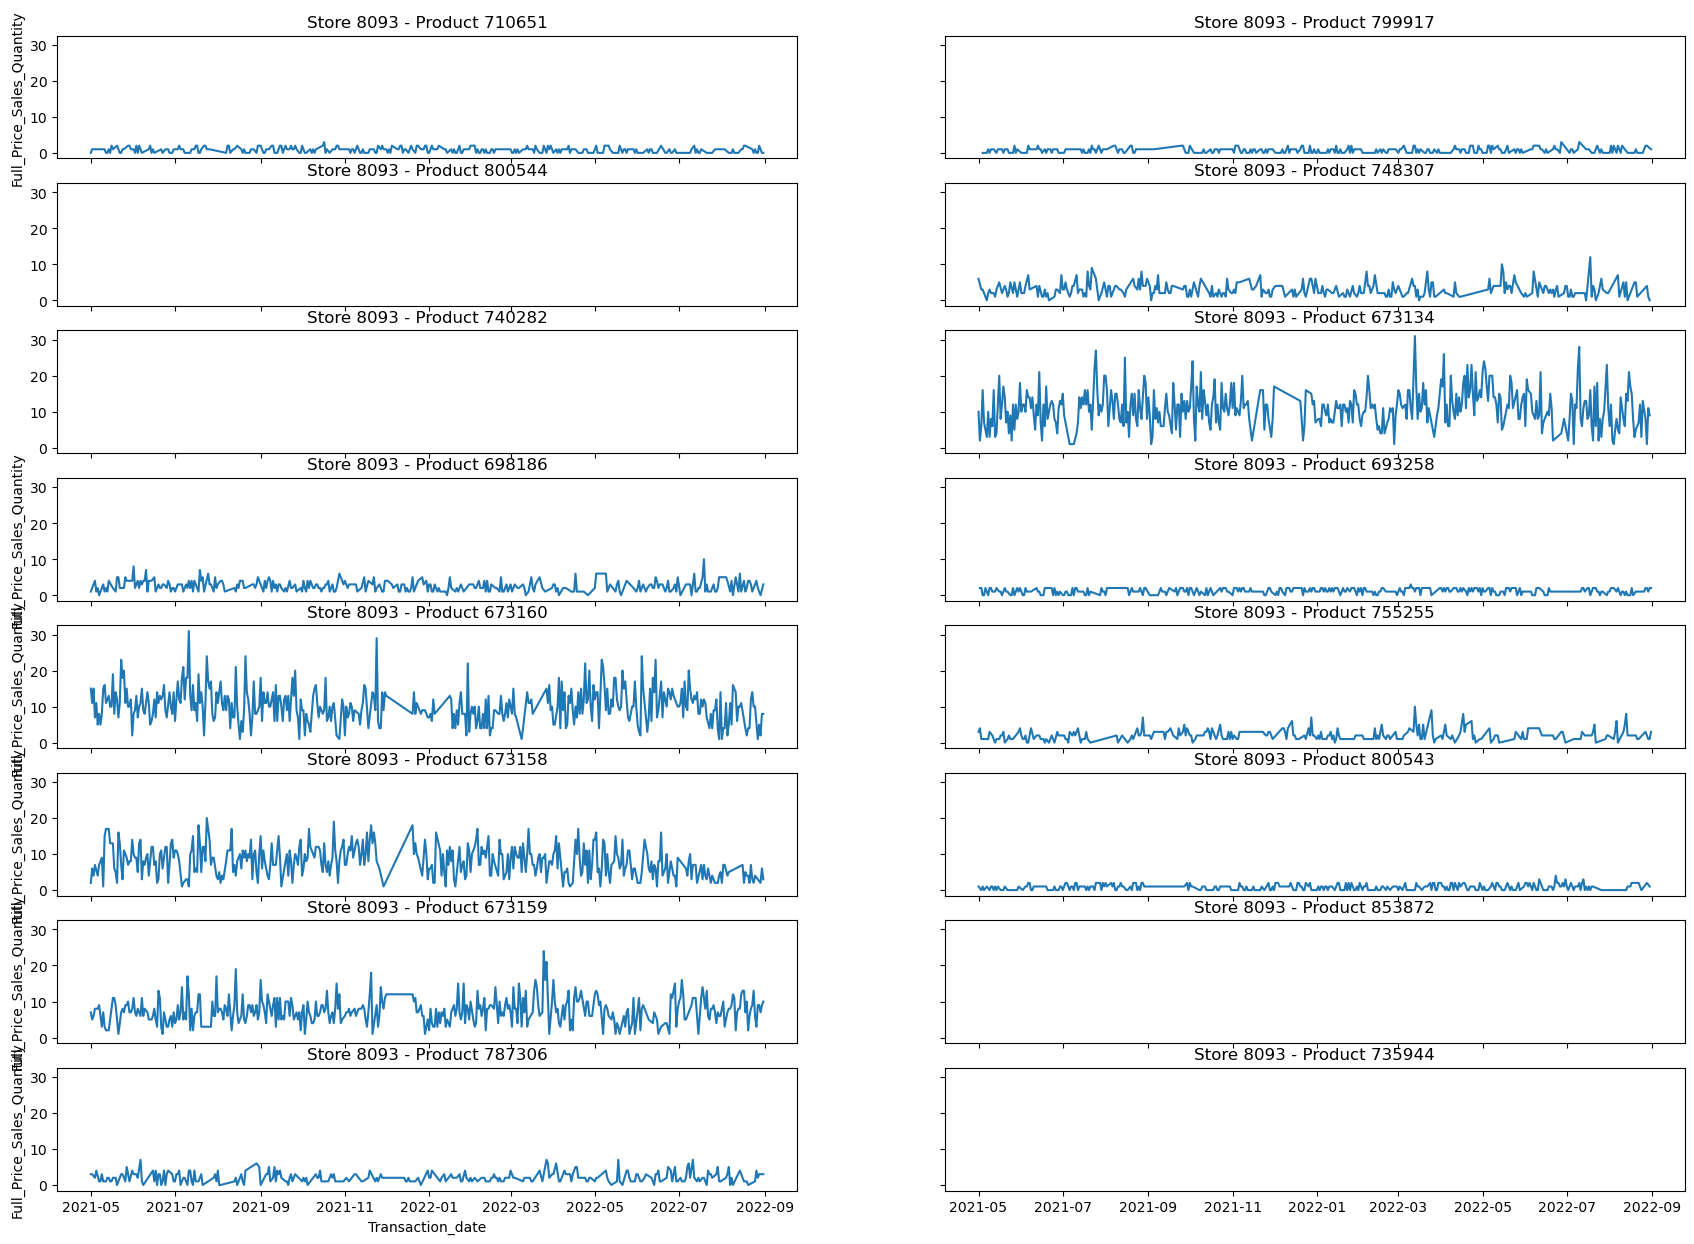

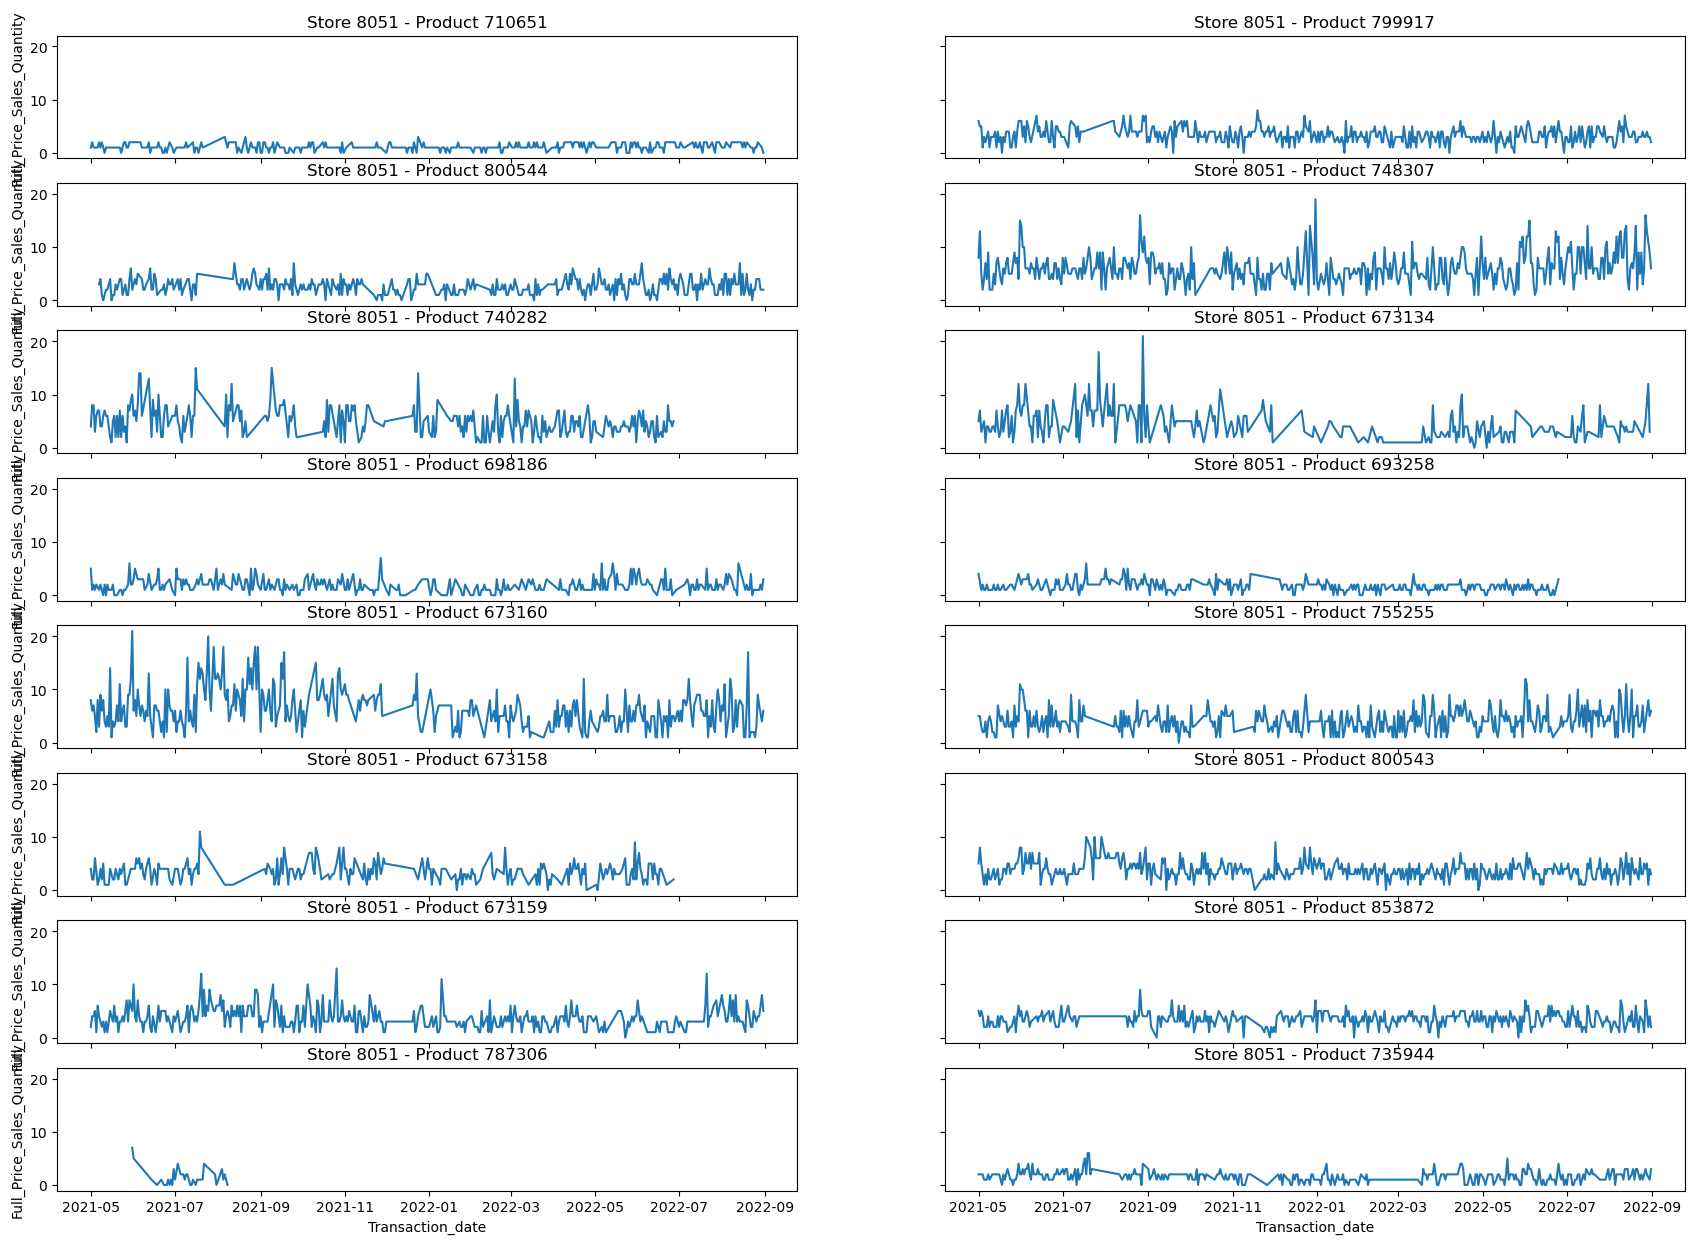

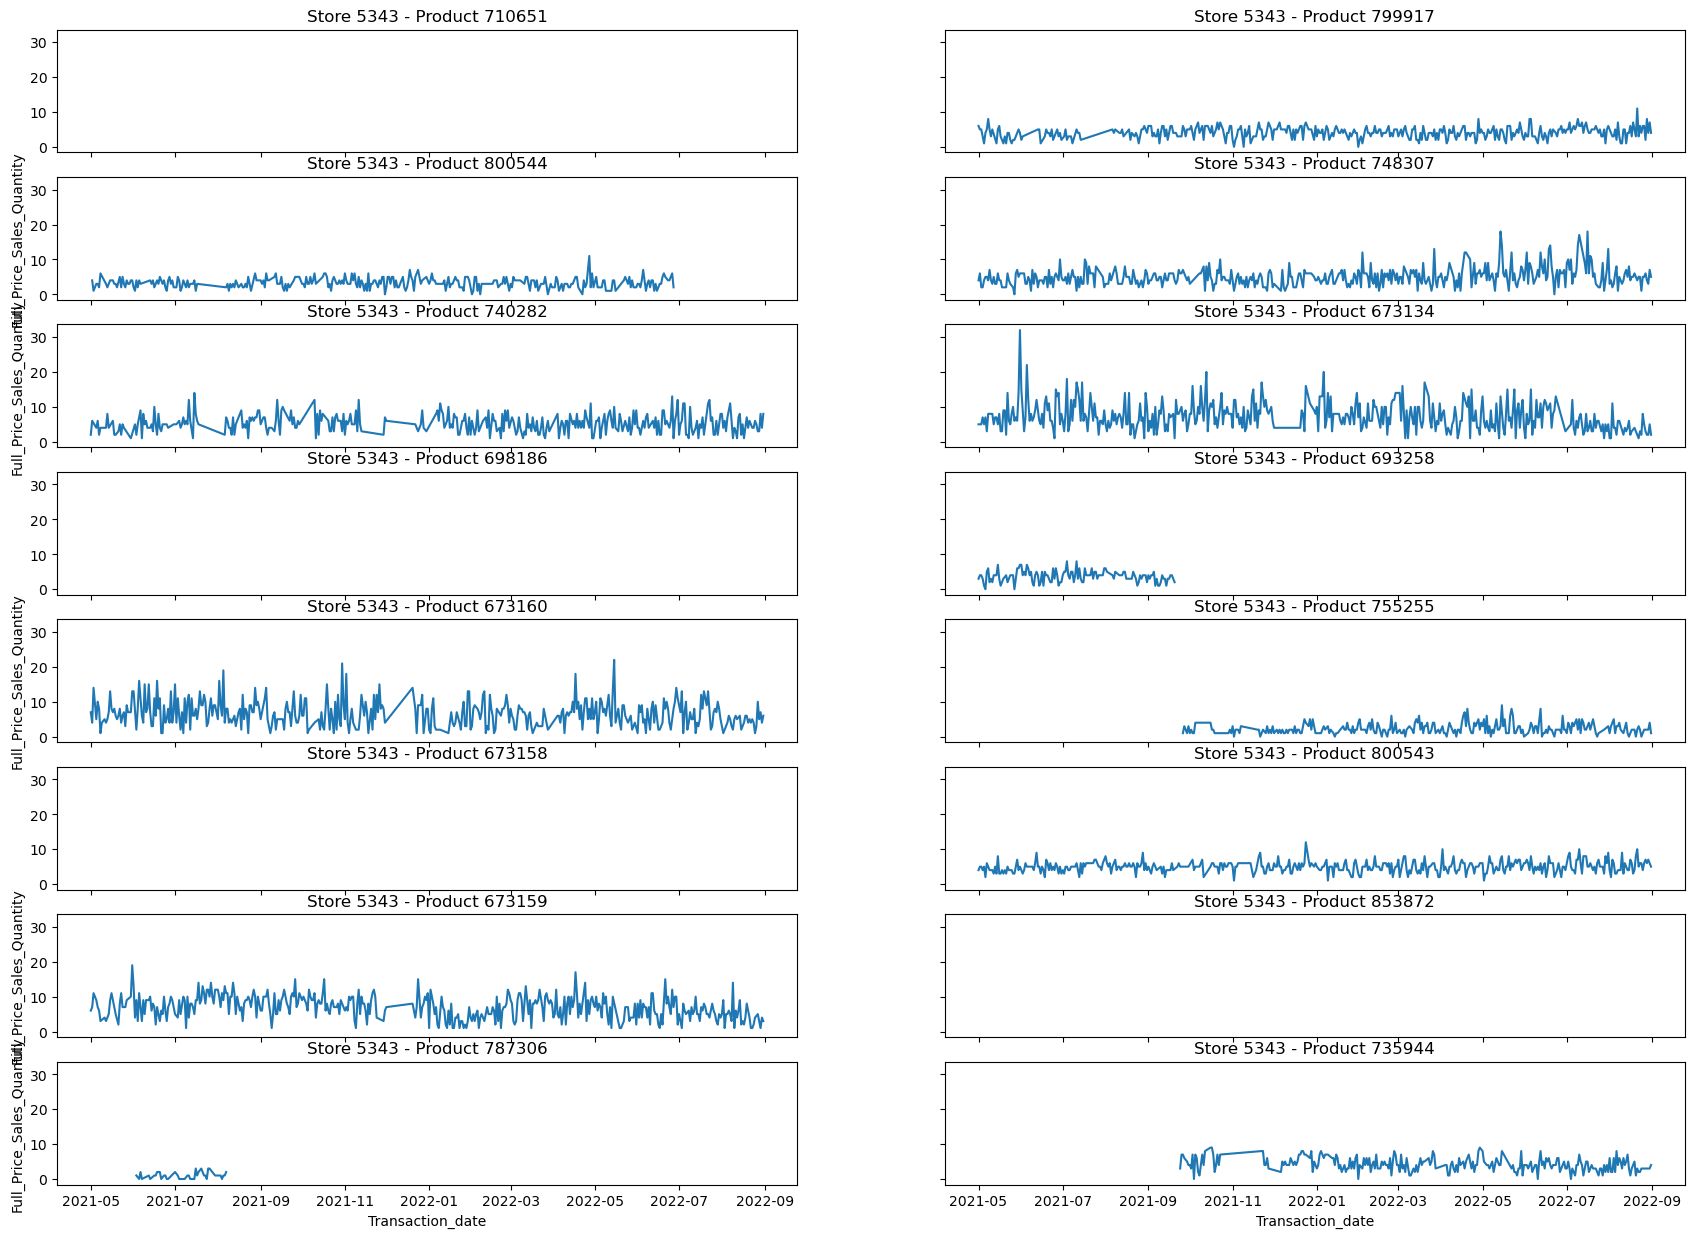

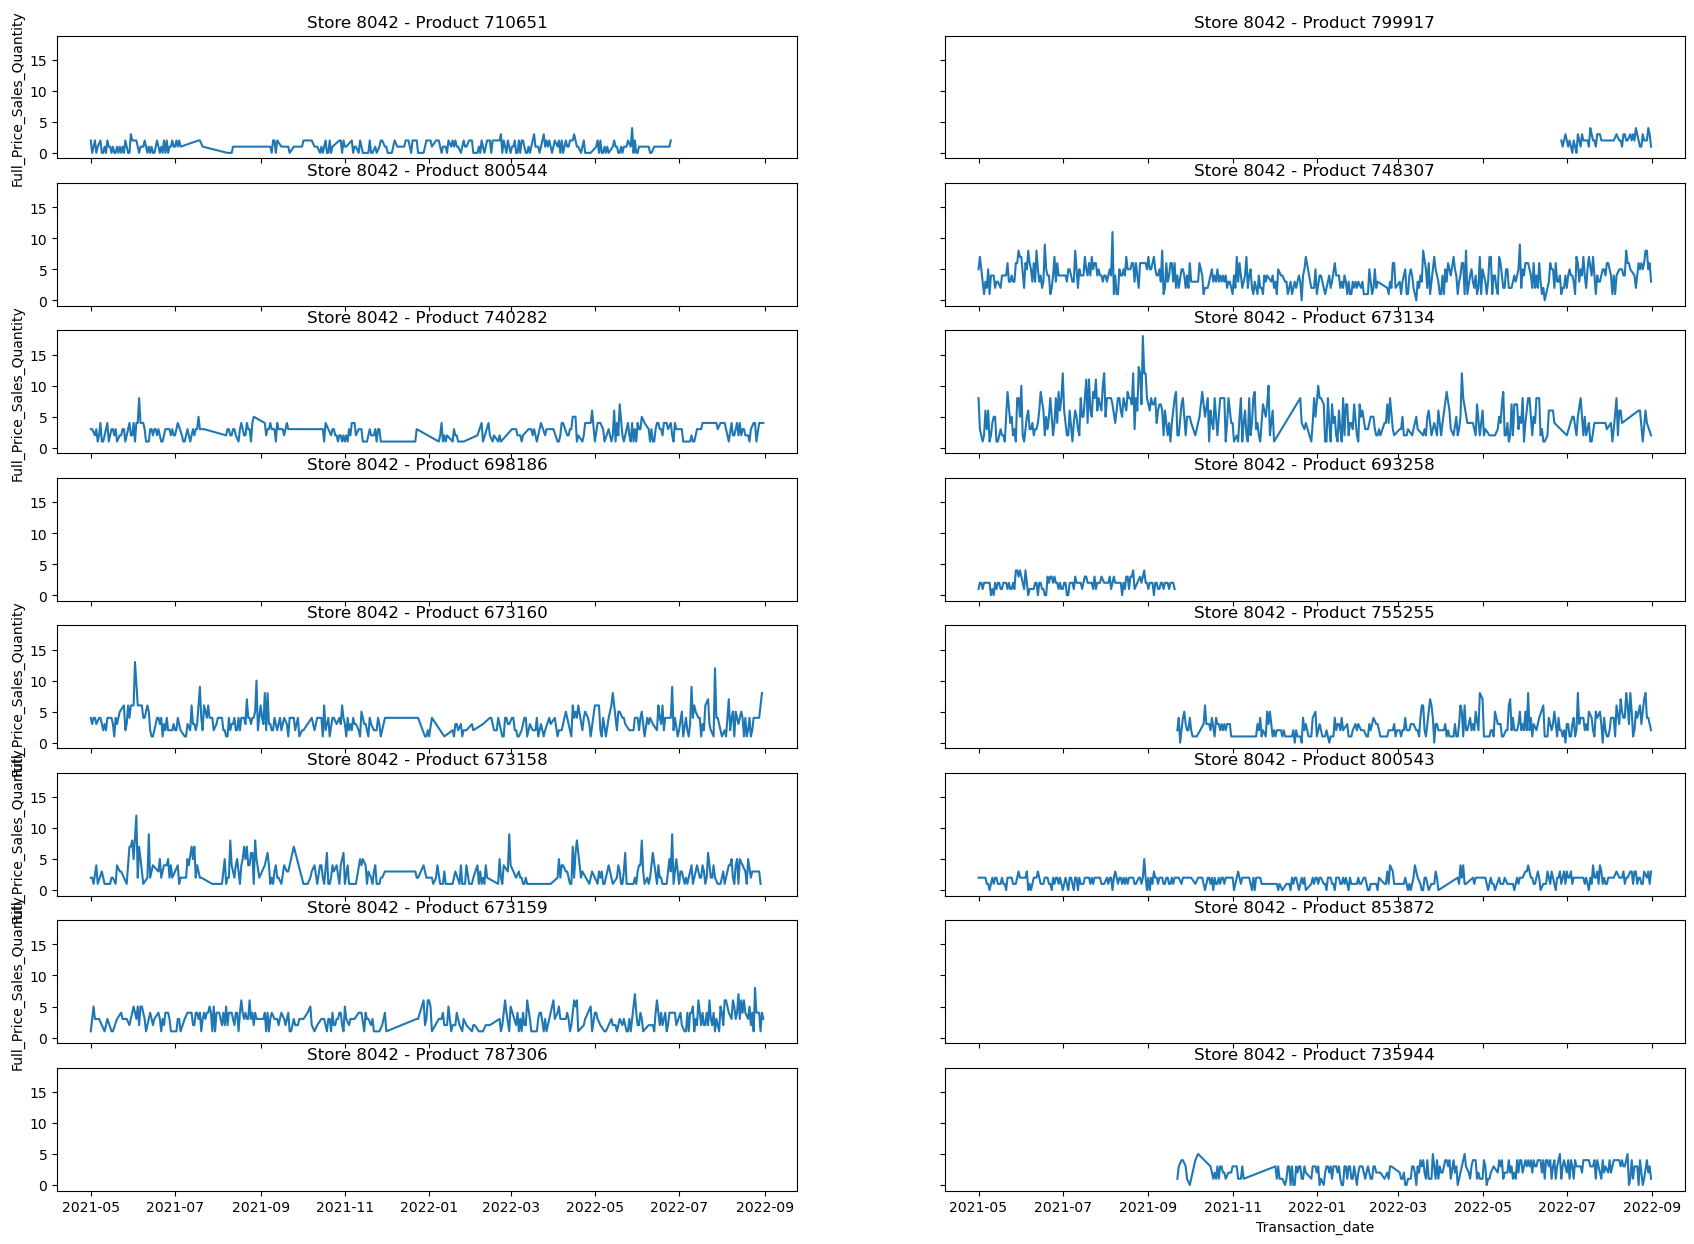

In [188]:
# Sales for all product-store combinations
def plot_store_product_sales(data):
    for store_num in data['Store_Number'].unique():
        data_store = data[(data['Store_Number']==store_num)]
        fig, axs = plt.subplots(ncols=2, nrows=8, sharex=True, sharey=True, figsize=(21, 15))
        i = 0
        for product in data['Product_Code'].unique():
            sns.lineplot(ax=axs[i%8,i//8], data=data_store[data_store['Product_Code']==product], x='Transaction_date', 
                         y='Full_Price_Sales_Quantity')
            axs[i%8,i//8].set_title("Store {} - Product {}".format(store_num, product))
            i += 1
plot_store_product_sales(data)

## Cleaning

In [190]:
# Class for cleaning data 
class VaccumCleaner:
    def __init__(self, data):
        self.data = data.copy()
    def filterStoreProduct(self, stores=None, products=None):
        # Filter data and only keep the given stores or products
        if stores != None:
            self.data = self.data[self.data.Store_Number.isin(stores)]
        if products != None:
            self.data = self.data[self.data.Product_Code.isin(products)]
    def drop(self, cols):
        # Drop given columns from dataset
        self.data.drop(cols, axis=1, inplace=True)
    def oneHotEncoder(self, cols):
        # Transform given columns to one-hot-encoded representation
        self.data = pd.get_dummies(self.data, columns=cols, drop_first=True)
    def extractDate(self):
        # Extract year and month from date
        self.data['Year'] = self.data['Transaction_date'].map(lambda x : x.year)
        self.data['Month'] = self.data['Transaction_date'].map(lambda x : x.month)
    def cycle(self, cols):
        # Transform cyclical features like Month
        cyclical = CyclicalFeatures(variables=cols, drop_original=False)
        self.data = cyclical.fit_transform(self.data)
    def normalize(self, cols):
        # Normalize given features
        scaler = MinMaxScaler()
        self.data[cols] = scaler.fit_transform(self.data[cols])

In [196]:
# Clean dataset
products = data.Product_Code.unique()
cleaned_data = [] # list of the sales history for each product
for product in products:
    cleaner = VaccumCleaner(data)
    cleaner.filterStoreProduct(products=[product])
    dropped_cols = ['Store_Name', 'Product_Description', 'Full_Price_Sales_Turnover',
              'Reduced_To_Clear_Quantity', 'Reduced_To_Clear_Turnover', 'MIDWEEK']
    cleaner.drop(dropped_cols)
    cleaner.extractDate()
    cleaner.cycle(['Month'])
    cleaner.drop('Month')
    # save store number for later
    cleaner.data['store_number'] = cleaner.data['Store_Number']
    cleaner.oneHotEncoder(['SubSect_Description', 'Weather_Rain', 'Year'])
    normalized_columns = ['Weather_Feels_Like', 'Weather_Cloud']
    cleaner.normalize(normalized_columns)
    cleaner.data.to_csv('CleanedData.csv')
    cleaned_data.append(cleaner.data.copy())

In [199]:
len(cleaned_data)

16

### separating stores 

In [212]:
def separate_stores(data):
    """ 
        This function gets a list of dataframes (each belongs to a certain product)
        and splits each one of them by the store number, leading to having a 
        dataframe for each store-product combination 
    """
    
    stores = data['store_number'].unique()
    datasets = []
    for store in stores:
        # splits by the store number
        data_store = data[data['store_number']==store]
        datasets.append(data_store)
    return datasets

data_stores = []
for data in cleaned_data:
    data_stores.append(separate_stores(data))
# Flatten the list
data_stores = [store for product in data_stores for store in product]

In [213]:
len(data_stores)

164

In [221]:
# Remove product-store combinations that have been discontinued 
final_data_stores = []
for data_store in data_stores: 
    if data_store.Transaction_date.iloc[-1] > datetime(2022,8,24):
        final_data_stores.append(data_store)
len(final_data_stores)

112

In [222]:
def make_datasets(data_stores):
    """
        This function receives a list of datasets of all store-product combinations, 
        and extract features, target variable (sales quantity), store number and product code out of it
    """
    datasets = []
    for data_store in data_stores:
        store = data_store['Store_Number'].unique()[0]
        product = data_store['Product_Code'].unique()[0]
        y = data_store['Full_Price_Sales_Quantity']
        cols = ['Store_Number', 'Product_Code', 'Transaction_date', 'store_number', 'Full_Price_Sales_Quantity']
        data_store.drop(cols, axis=1, inplace=True)
        datasets.append((data_store, y, store, product))
    return datasets

datasets = make_datasets(final_data_stores)

In [251]:
# multivariate LSTM

# split a multivariate sequence into samples suitable for training an LSTM model
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps
         # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# save the results of prediction for the last week for every store-product combination
results = {
    'store' : [],
    'product' : [],
    'RMSE' : [],
}
results = pd.DataFrame(results)

for dataset in datasets:
    # retrieve features, target variable, product and store 
    X, y, store, product = dataset[0], dataset[1], dataset[2], dataset[3]
    # feature engineering 
    df_rolled_3d = y.rolling(window=3, min_periods=0)
    df_rolled_7d = y.rolling(window=7, min_periods=0)
    df_rolled_30d = y.rolling(window=30, min_periods=0)

    df_mean_3d = df_rolled_3d.mean().reset_index().astype(np.float32)['Full_Price_Sales_Quantity']
    df_mean_7d = df_rolled_7d.mean().reset_index().astype(np.float32)['Full_Price_Sales_Quantity']
    df_mean_30d = df_rolled_30d.mean().reset_index().astype(np.float32)['Full_Price_Sales_Quantity']

    # horizontally stack columns
    y = y.values.reshape(-1, 1)
    df_mean_3d = df_mean_3d.values.reshape(-1, 1)
    df_mean_7d = df_mean_7d.values.reshape(-1, 1)
    df_mean_30d = df_mean_30d.values.reshape(-1, 1)
    
    # Combine all columns together 
    dataset = hstack((X.iloc[1:,:], df_mean_3d[1:,:], df_mean_7d[1:,:], df_mean_30d[1:,:], y[1:,:]))
    # choose a number of time steps
    n_steps = 7
    # train/test split
    train_dataset, test_dataset = dataset[:-1*n_steps,:], dataset[-2*n_steps+1:,:]
    # convert into input/output
    X_train, y_train = split_sequences(train_dataset, n_steps)
    X_test, y_test = split_sequences(test_dataset, n_steps)
    # the dataset knows the number of features, e.g. 2
    n_features = X_train.shape[2]
    # define model
    model = Sequential()
    model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps, n_features))))
#     model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True)))
#     model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=False)))
#     model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X_train, y_train, epochs=50, verbose=0)
    yhat = model.predict(X_test, verbose=0)
    mse = metrics.mean_squared_error(y_test, yhat)
    rmse = math.sqrt(mse)
    print('Root Mean Squared Error (RMSE) for store {}, product {}:'.format(store, product), rmse)
    new_row = {'store':store, 'product':product, 'RMSE':rmse}
    results = results.append(new_row, ignore_index=True)


Root Mean Squared Error (RMSE) for store 5751, product 710651: 1.0644074344687229
Root Mean Squared Error (RMSE) for store 5147, product 710651: 1.4832885717429964
Root Mean Squared Error (RMSE) for store 8093, product 710651: 0.7360013988293902
Root Mean Squared Error (RMSE) for store 8051, product 710651: 0.698980584643137
Root Mean Squared Error (RMSE) for store 5147, product 800544: 1.7379409634089023
Root Mean Squared Error (RMSE) for store 8051, product 800544: 1.1814316048809639
Root Mean Squared Error (RMSE) for store 5751, product 800544: 1.596547519346902
Root Mean Squared Error (RMSE) for store 5147, product 740282: 3.314228785037214
Root Mean Squared Error (RMSE) for store 8042, product 740282: 1.3108986360579105
Root Mean Squared Error (RMSE) for store 8048, product 740282: 0.8685146805352326
Root Mean Squared Error (RMSE) for store 5343, product 740282: 1.9924948085608492
Root Mean Squared Error (RMSE) for store 3446, product 740282: 0.9460389291048971
Root Mean Squared E

Root Mean Squared Error (RMSE) for store 8051, product 853872: 1.9724804554348954
Root Mean Squared Error (RMSE) for store 5147, product 853872: 17.60590188950004
Root Mean Squared Error (RMSE) for store 8051, product 735944: 0.8560465341444866
Root Mean Squared Error (RMSE) for store 5147, product 735944: 2.1177158598518777
Root Mean Squared Error (RMSE) for store 5751, product 735944: 1.0319189241414748
Root Mean Squared Error (RMSE) for store 3446, product 735944: 1.6941036207721467
Root Mean Squared Error (RMSE) for store 8042, product 735944: 1.4345771920010522
Root Mean Squared Error (RMSE) for store 6002, product 735944: 1.0933598264010824
Root Mean Squared Error (RMSE) for store 7867, product 735944: 1.0686621907188354
Root Mean Squared Error (RMSE) for store 8048, product 735944: 1.0441163811505876
Root Mean Squared Error (RMSE) for store 5343, product 735944: 1.71513225361741


In [255]:
results.RMSE.mean()

2.1141774428406492

# Random Forrest model 

In [98]:
#method to perform regression (apply this method on each product group)
def randomForest(data):
    # Sort data based on date
    data = data.sort_values(by='Transaction_date', ascending=True)
    #create seperate variable for the labels i.e. the quantity
    labels = np.array(data['Full_Price_Sales_Quantity'])
    #storing the dates and stores for plotting
    dates = data['Transaction_date']
    stores = data['store_number']
    
    # Remove the labels from the features
    data= data.drop('Full_Price_Sales_Quantity', axis = 1)
    #drop features that dont need to be included in training
    ######## should i remove turnover too?? (*** with turnover gives really good model)
    #data = data.drop(['Store_Number', 'Transaction_date','Product_Code'], axis = 1)
    data = data.drop(['Transaction_date', 'store_number'], axis = 1)
    # Saving feature names for later use
    featureList = list(data.columns)
    
    # Convert to numpy array
    data = np.array(data)
    
    #do train test split on the data and labels (using 15% on test for now)
    #train_size = math.ceil(0.85 * len(data))

    # Compute test size for the last week 
    test_size = len([d for d in dates if d >= datetime(2022,8,24)])
    train_size = len(dates) - test_size

    trainFeatures, testFeatures, trainLabels, testLabels = \
                                data[:train_size], data[train_size:], labels[:train_size], labels[train_size:]
    #trainFeatures, testFeatures, trainLabels, testLabels = train_test_split(data, labels, test_size = 0.15, random_state = 42)
    #return (train_features, test_features, train_labels, test_labels)
    
    # All different options for hyperparameters 
    # Adjust these two parameters
    criteria = ["squared_error"]
    max_depths = [4]
    # Min MSE of all different settings
    min_mse, best_criterion, best_max_depth = 1000, None, 0
    
    for criterion in criteria:
        for max_depth in max_depths:
            #train model using random forest
            # Instantiate model with 1000 decision trees
            regressor = RandomForestRegressor(n_estimators = 1000, max_depth = max_depth, 
                                              criterion = criterion, random_state = 42)
            # Train the model on training data
            regressor.fit(trainFeatures, trainLabels)
            
            #make predictions
            predictions = regressor.predict(testFeatures);
            train_predictions = regressor.predict(trainFeatures);
            
            # Calculate error
            mse_err = metrics.mean_squared_error(testLabels, predictions)
            if mse_err < min_mse:
                min_mse = mse_err
                best_criterion = criterion
                best_max_depth = max_depth
            
            ####getting feature importances
            importances = list(regressor.feature_importances_)
            # List of tuples with variable and importance
            feature_importances = [(data, round(importance, 2)) for data, importance in zip(featureList, importances)]
            # Sort the feature importances by most important first
            feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
            # Print out the feature and importances 
            [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
            ###******** next time we can train again with the 3 most important features
            
            #testing dates
            splitNum = labels.size - testLabels.size

            # Dataframe with true values and dates - this is for you want to view the whole dataset
            #true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

            predictionDates = dates.iloc[splitNum:]
            predictionStores = stores.iloc[splitNum:]
            
            print(np.unique(predictionStores))

            test_data = pd.DataFrame(data = {'date': predictionDates, 'actual': testLabels, \
                                             'store' : predictionStores})
            # Dataframe with test, predictions and dates
            predictions_data = pd.DataFrame(data = {'date': predictionDates, 'prediction': predictions, \
                                            'store' : predictionStores})
            
            # Print characteristics of the model
            print("Criterion used :", criterion)
            print("Depth used :", max_depth)
            print('Mean Squared Error (MSE):', metrics.mean_squared_error(testLabels, predictions))
            print('R-squared Error for training data:', r2_score(trainLabels, train_predictions))
            print('R-squared Error for test data:', r2_score(testLabels, predictions))
            print('RMSE for train data:', mean_squared_error(trainLabels, train_predictions, squared=False))
            print('RMSE for test data:', mean_squared_error(testLabels, predictions, squared=False))
            
            for i, store in enumerate(np.unique(predictionStores)):
                fig = plt.figure(i/5)
                ax = fig.add_subplot(5, 1, (i%5)+1)
                # Plot the actual values
                plt.scatter(test_data[test_data.store == store]['date'], test_data[test_data.store == store]['actual'], c = 'b', label = 'actual')
                # Plot the predicted values
                plt.scatter(predictions_data[predictions_data.store==store]['date'], predictions_data[predictions_data.store==store]['prediction'], c = 'r', label = 'prediction')
                plt.xticks(rotation = '60'); 
                ax.legend(bbox_to_anchor=(1.1, 1.05))
                # Graph labels
                plt.xlabel('Date'); plt.ylabel('Quantity'); plt.title('Actual and Predicted Values for store {}'.format(store));

                plt.show()
            
            plt.figure(2, figsize=(25,25))
            _ = tree.plot_tree(regressor.estimators_[0], feature_names=featureList, filled=True, fontsize=10)
            plt.savefig('tree{}.png'.format(max_depth), bbox_inches='tight')

#     print("Best criterion :", best_criterion)
#     print("Best max_depth :", best_max_depth)
#     print("Min MSE error :", min_mse)
    
#     # Build the best model
#     regressor = RandomForestRegressor(n_estimators = 1000, max_depth = best_max_depth, 
#                                               criterion = best_criterion, random_state = 42)
#     regressor.fit(trainFeatures, trainLabels)
#     predictions = regressor.predict(testFeatures);
    
#     ####getting feature importances
#     importances = list(regressor.feature_importances_)
#     # List of tuples with variable and importance
#     feature_importances = [(data, round(importance, 2)) for data, importance in zip(featureList, importances)]
#     # Sort the feature importances by most important first
#     feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
#     # Print out the feature and importances 
#     [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
#     ###******** next time we can train again with the 3 most important features

#     #testing dates
#     splitNum = labels.size - testLabels.size
    
#     # Dataframe with true values and dates - this is for you want to view the whole dataset
#     #true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})
    
#     predictionDates = dates.iloc[splitNum:]
    
#     test_data = pd.DataFrame(data = {'date': predictionDates, 'actual': testLabels})
#     # Dataframe with test, predictions and dates
#     predictions_data = pd.DataFrame(data = {'date': predictionDates, 'prediction': predictions})
    
#     # Plot the actual values
#     plt.plot(test_data['date'], test_data['actual'], 'b-', label = 'actual')
#     # Plot the predicted values
#     plt.plot(predictions_data['date'], predictions_data['prediction'], 'r-', label = 'prediction', alpha=0.5)
#     plt.xticks(rotation = '60'); 
#     plt.legend()
#     # Graph labels
#     plt.xlabel('Date'); plt.ylabel('Quantity'); plt.title('Actual and Predicted Values');
    
#     plt.show()
    
    return (predictions, testLabels, featureList, importances)
    
    
def performanceMetrics(prediction, testLabels):
        
    #add more to get accuracy, R^2 score, RMSE etc
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(testLabels, predictions))
    print('Mean Squared Error (MSE):', metrics.mean_squared_error(testLabels, predictions))
    print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(testLabels, predictions)))
    

Variable: Store_Number_5147    Importance: 0.63
Variable: Store_Number_8093    Importance: 0.18
Variable: Year_2022            Importance: 0.07
Variable: Weather_Feels_Like   Importance: 0.02
Variable: Month_cos            Importance: 0.02
Variable: Store_Number_5343    Importance: 0.02
Variable: SATURDAY             Importance: 0.01
Variable: Weather_Cloud        Importance: 0.01
Variable: Month_sin            Importance: 0.01
Variable: Store_Number_7867    Importance: 0.01
Variable: MONDAY               Importance: 0.0
Variable: TUESDAY              Importance: 0.0
Variable: WEDNESDAY            Importance: 0.0
Variable: THURSDAY             Importance: 0.0
Variable: FRIDAY               Importance: 0.0
Variable: WEEKEND              Importance: 0.0
Variable: BH_FLAG              Importance: 0.0
Variable: SPRING               Importance: 0.0
Variable: SUMMER               Importance: 0.0
Variable: AUTUMN               Importance: 0.0
Variable: SERVICE_TIME         Importance: 0.0
Var

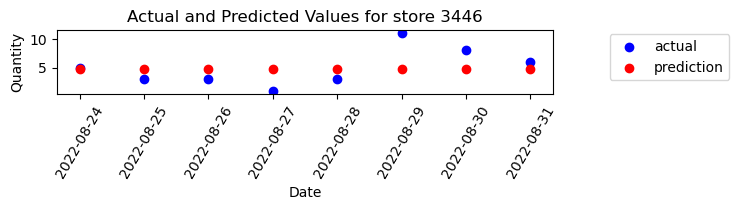

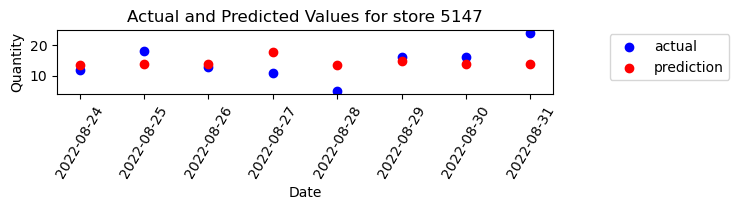

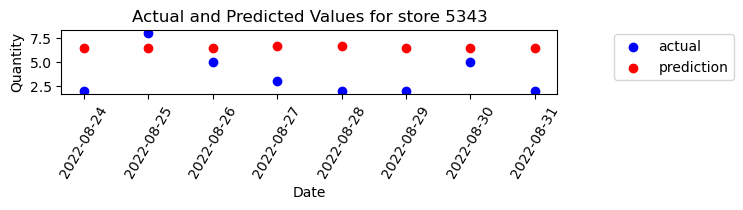

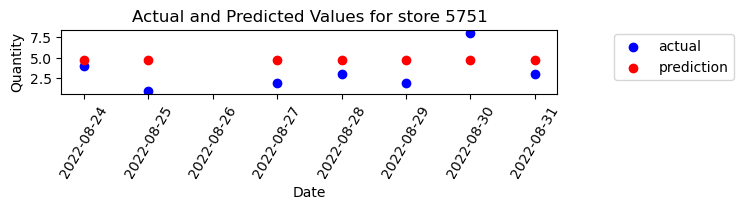

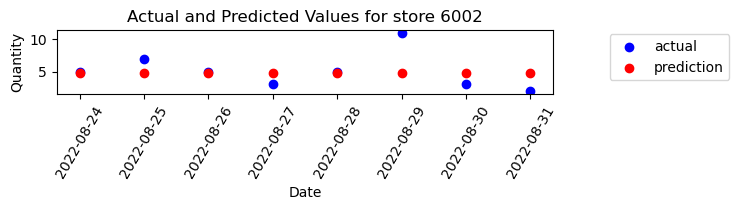

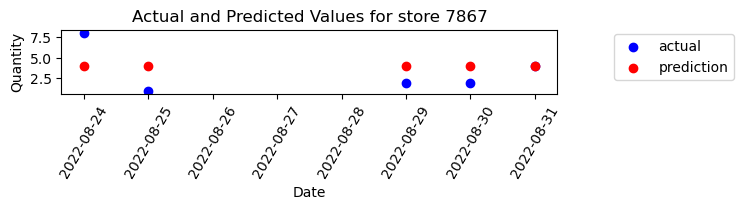

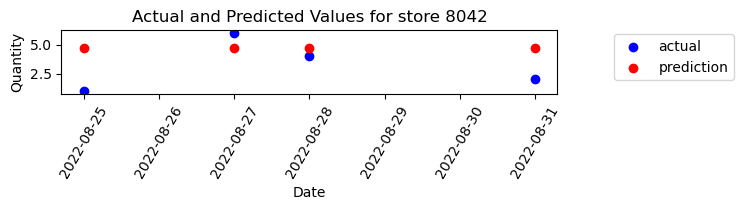

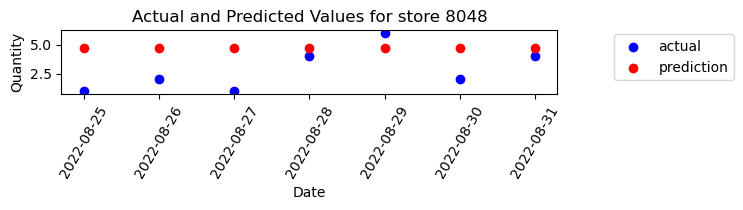

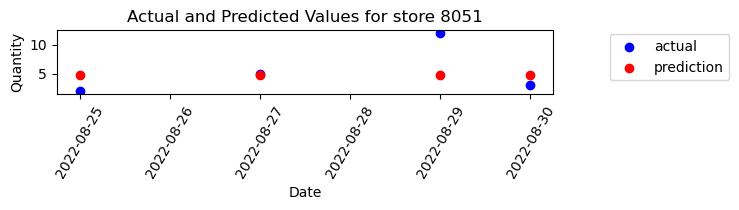

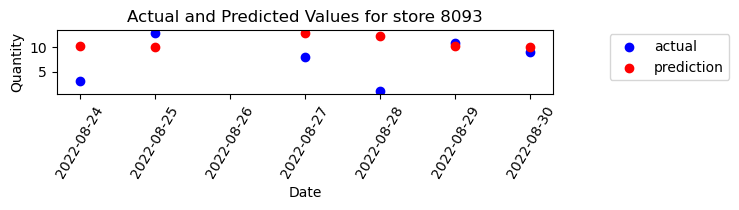

Mean Absolute Error (MAE): 2.9077461733039422
Mean Squared Error (MSE): 14.042618557901472
Root Mean Squared Error (RMSE): 3.747348203450204


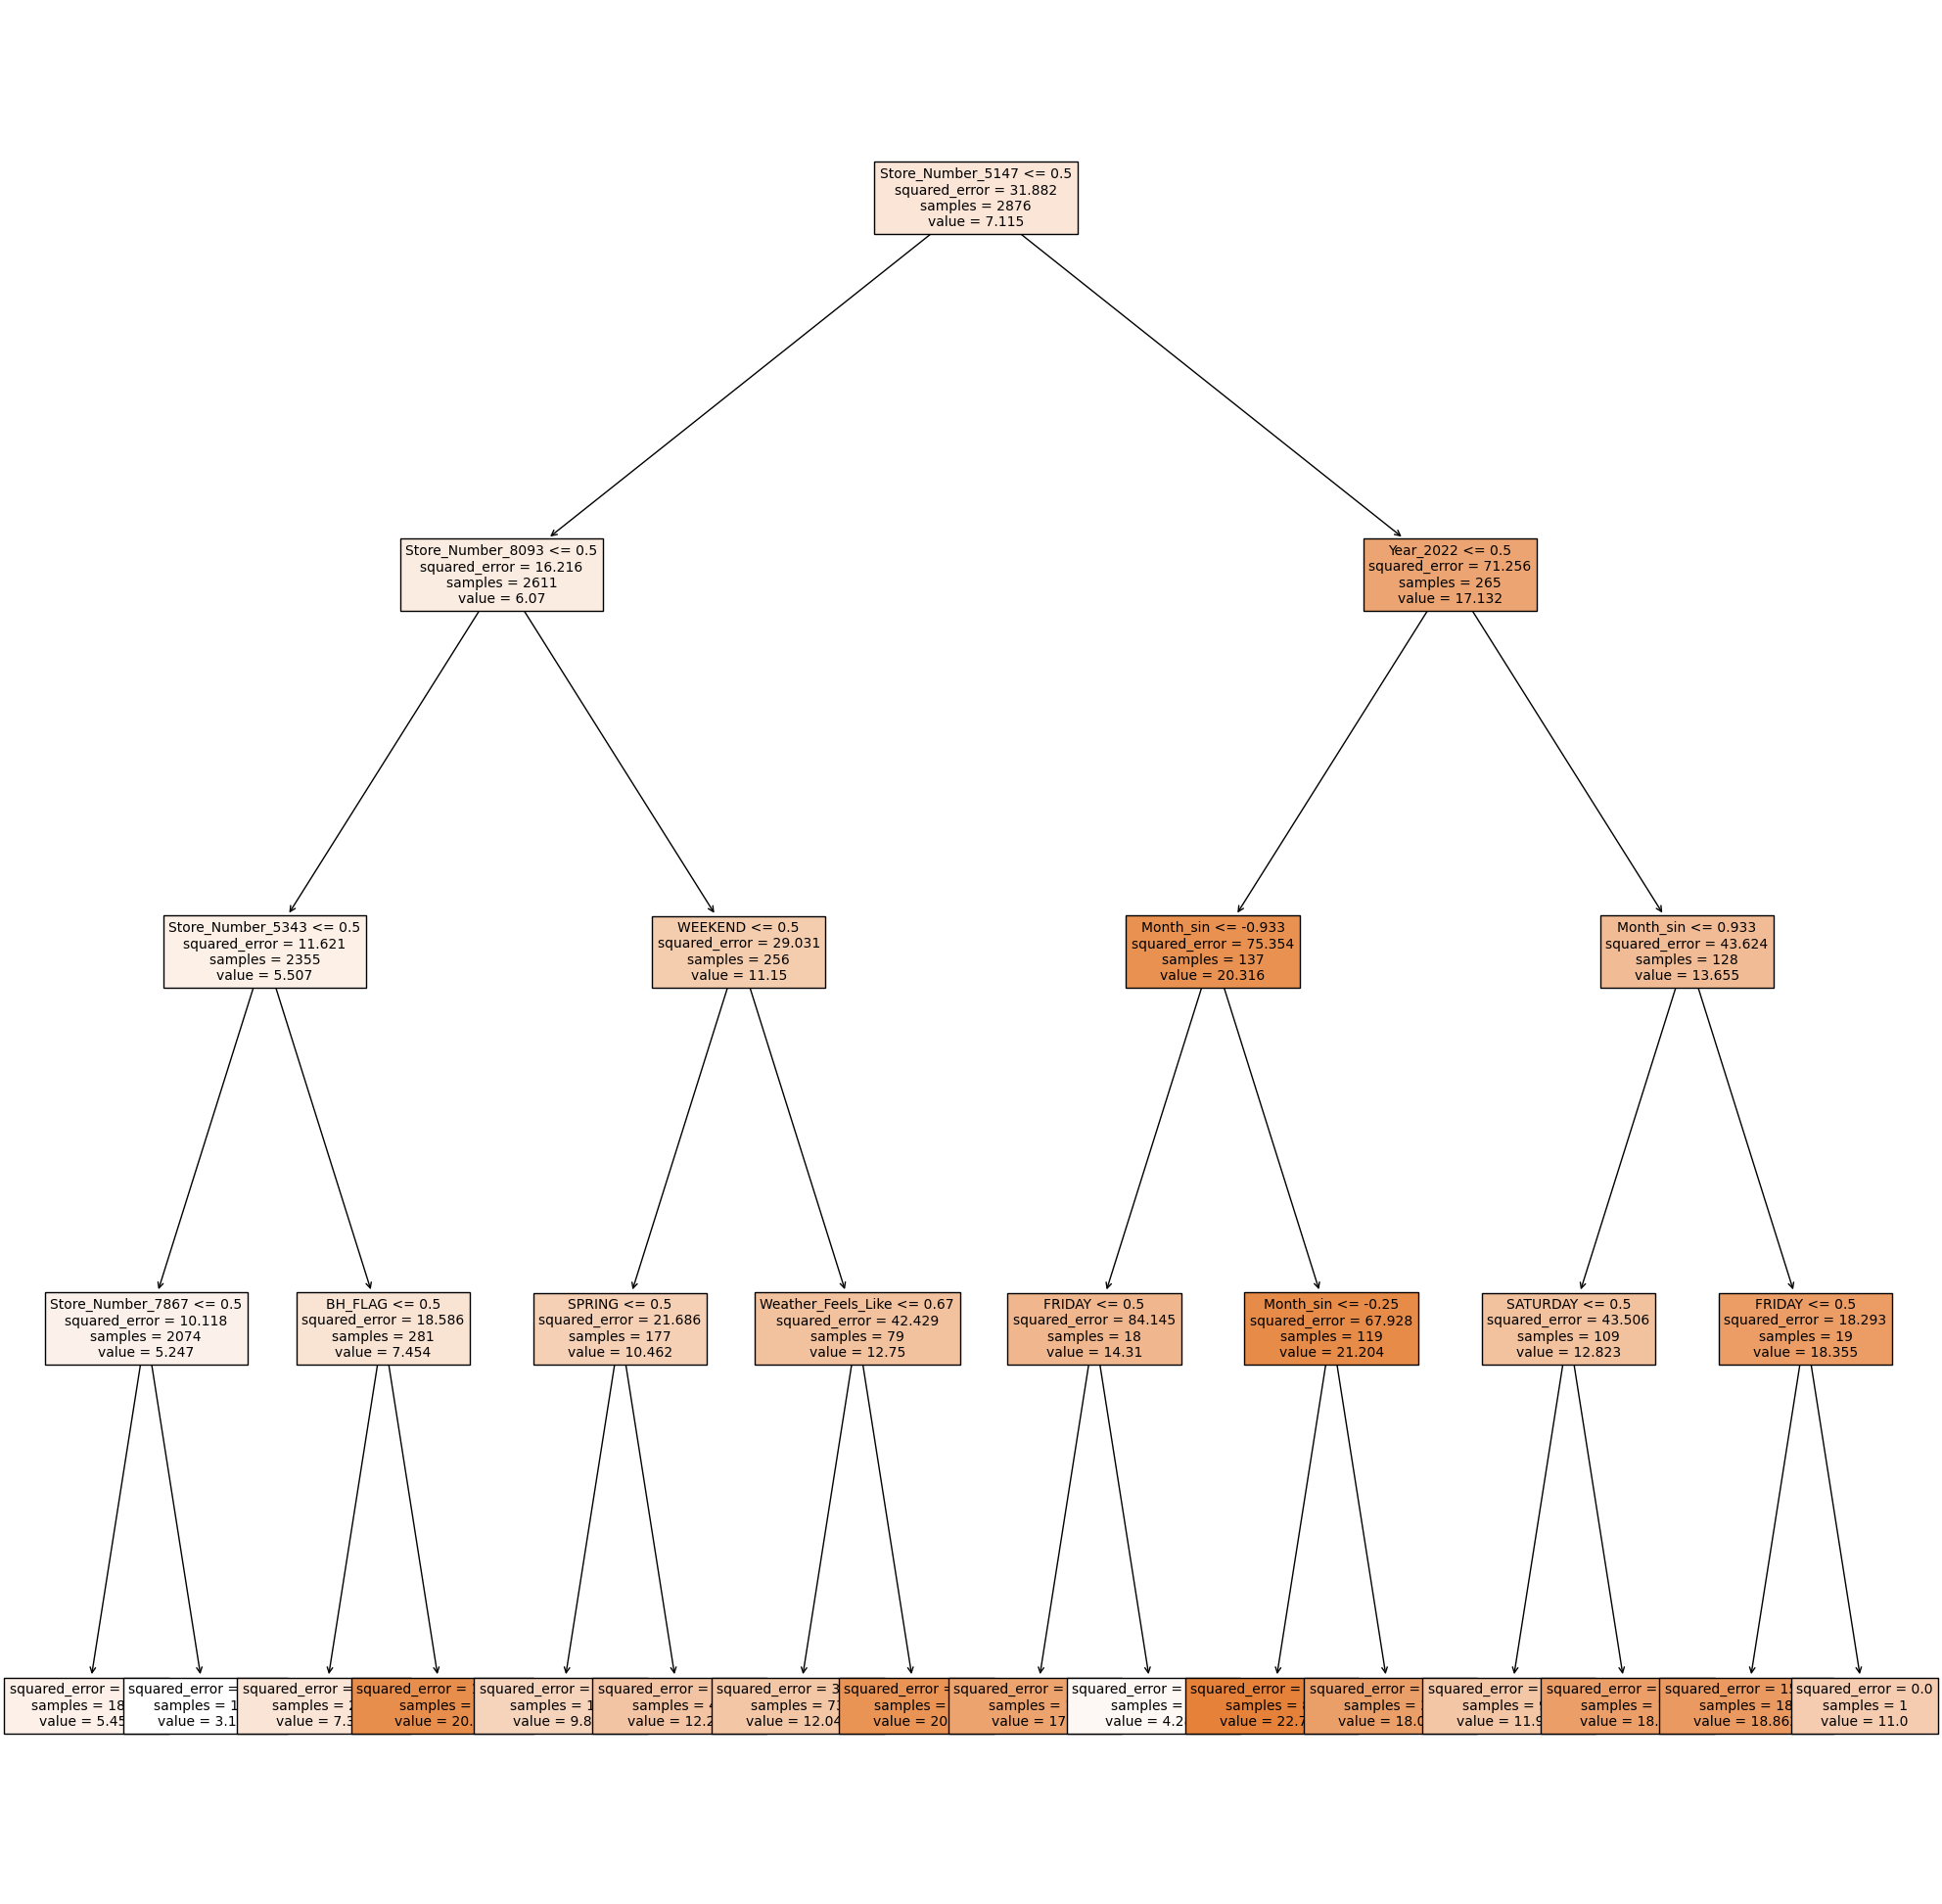

In [99]:
predictions, testLabels, featureList, importances = randomForest(cleaned_data)
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(testLabels, predictions))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(testLabels, predictions))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(testLabels, predictions)))

Variable: Store_Number         Importance: 0.4
Variable: Weather_Feels_Like   Importance: 0.18
Variable: OPENING_TIME         Importance: 0.11
Variable: Weather_Cloud        Importance: 0.09
Variable: Weather_Rain         Importance: 0.04
Variable: MONDAY               Importance: 0.02
Variable: TUESDAY              Importance: 0.02
Variable: THURSDAY             Importance: 0.02
Variable: FRIDAY               Importance: 0.02
Variable: SATURDAY             Importance: 0.02
Variable: SPRING               Importance: 0.02
Variable: AUTUMN               Importance: 0.02
Variable: WEDNESDAY            Importance: 0.01
Variable: MIDWEEK              Importance: 0.01
Variable: WEEKEND              Importance: 0.01
Variable: BH_FLAG              Importance: 0.01
Variable: SUMMER               Importance: 0.01
Variable: Product_Code         Importance: 0.0
Variable: CLOSING_TIME         Importance: 0.0


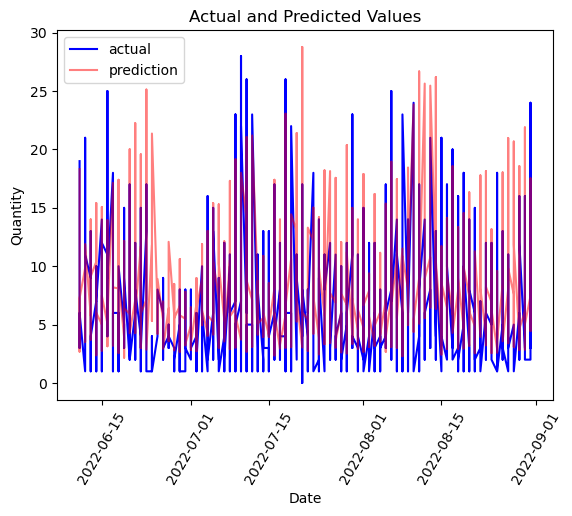

Mean Absolute Error (MAE): 3.476562197936549
Mean Squared Error (MSE): 21.946376609190413
Root Mean Squared Error (RMSE): 4.684695999655731


In [97]:
predictions2, testLabels2, featureList2, importances2 = randomForest(raw_data)
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(testLabels2, predictions2))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(testLabels2, predictions2))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(testLabels2, predictions2)))